<font size=6  color=#003366> [LGBIO2020] - Bioinstrumentation <br><br> 
Project EEG classification : Open your eyes!   </font> <br><br><br>

<font size=5  color=#003366>
Prof. M. Verleysen (supp. D. Mulders)<br>
Prof. A. Moureaux<br>
</font>
<br>
<br>

<font size=5 color=#009999> <b>GLOBAL CONTEXT </b> <br>
DEFINITION OF EEG CLASSIFICATION 
</font> <br> <br>

The aim of this project is to distinguish short segments of an EEG signal recorded in a subject whose eyes are either closed or open. In other words, you will train a binary classifier taking as input (features extracted from) a 500 ms EEG signal and for wich the prediction is the state of the subject (either eyes closed or open). To reach this goal, you will work on a real dataset recoded in the laboratory of Woluwe.</b> <br>

You will have to pre-process the obtained dataset, extract relevant features and finally tackle the classification task. Some guidelines are given along this notebook. <b> The comments/justifications that you will provide are crutial for this project! </b> <br>

In addition to this notebook, you are asked to  <b>write a report (pdf file - max. 5 pages, appendices are allowed) documenting all the choices that you have made regarding the processing steps. You should also present and comment your main results. </b> Do not hesitate to consult books or internet ressources. This is allowed to use them to answer the questions as long as you cite your references.


<br>

<img src="imgs/Context.png" width = "600">

The context of this project is illustrated in the figure above. First, you will be asked to extract segments of 500 ms out of the recorded EEG waves. During each segment, the state of the subject (eyes open or closed) must be constant. Based on these segments, you will extract some usefull features that will help to summarize the information content in those 500 ms signals. Then, you will train a classifier to predict whether a given new segment belongs to the "eyes open" or the "eyes closed" class. You will have to predict the performances you can obtain with this classification model.
<br><br>


<font size=5 color=#009999> <b> STRUCTURE OF THE PROJECT </b> <br>
WHAT ARE THE MAIN STEPS?
</font> <br> <br>

The project is divided into three parts : Data Precprocessing, Feature Generation and Classification. Those are illustrated in the figure below. 

   - In the first step, you will have to convert the entire recorded signal into segments that correspond either to the eyes closed or eyes open condition. During this phase, you will perfom basic signal processing operation to clean you data and make the classification easier. 
   - Then, based on the segments you have constructed, you will represent each of them by a collection of features. 
   - Finally, you will train some classification models on your features. You will have to estimate the performances obtained with the models.

<img src="imgs/blockdiagram.png" width = "800">


Note that those operations have been adressed during the three practical sessions. Do not hesitate to base this project on the code/observations you have already made during those sessions. 

<br> 


<font size=5 color=#009999> <b> INSTRUCTIONS </b> <br>
WORK BY GROUP AND DELIVERABLES
</font> <br> <br>

You can discuss about the project with other students, but your work has to be implemented either individually or in groups of two. You must submit on Moodle an archived folder containing:
   
   - Your notebook file with (at least) your codes and (eventually) small remarks. If it is necessary, you can join a README.txt file explaining how to run your codes. The results presented in your report should be reproducible with these codes. Make sure that we can compile them properly (for instance if you used a different toolbox than the ones provided on Moodle, you should include the associated files in your submission).
   - A pdf report of maximum 5 pages that presents your results and justifies your choices. You can write it in English or in French. This report is very important! Do not neglet the writing. It is recommended to illustrate and comment as much as possible your results (when it applies).
   
Don’t forget to mention the name(s) of the author(s) in the notebook and in the report.

<br><br>


<font size=6 color=#009999> <center><b>PART I - DATA PREPROCESSING </b></center> </font> <br> <br>

<font size=5 color=#009999> <b>PROJECT DATA </b> <br>
HOW ARE THE DATA STORED?
</font> <br> <br>

The EEG signal on which we are working have been recorded in the Wolluwe's laboratory. This dataset includes 64 recording channels corresponding to the montage below:

<img src="imgs/Montage64.png" width = "500">

The sampling rate of these recordings is 1024Hz.<br><br>

You have 3 files at your disposal:
   - <samp>data_closed.csv</samp> contains the signals of dimension $ch \times t$, where $t$ is the number of recorded time steps and $ch$ is the number of electrodes. Those signals correspond to <b>eyes closed</b> condition. 
   - <samp>data_open.csv</samp> contains the signals of dimension $ch \times t$, where $t$ is the number of recorded time steps and $ch$ is the number of electrodes. Those signals correspond to <b>eyes open</b> condition. 
   -  <samp>ChannelNames.csv</samp> contains a $ch \times 1$ vector with the name of each electrode.
   
<div class="alert alert-info">
<b>[Question 1] Import the data and visualize them</b>  <br>
Import the signals stored in the <samp>*.csv</samp> files. As usually in a machine learning process, a simple data visualization step will help you to understand the nature of the task. You can use the <samp>ecg_plot</samp> provided in the TP1 or any other provided function. Of course, you can modify this code if you want. 
</div> 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import mne
from mne import create_info
from mne.io import RawArray
from mne.viz import plot_raw, plot_raw_psd

In [2]:
# import datasets
channels = pd.read_csv("channel_names.csv", names = ['names'])
eyes_closed = pd.read_csv("data_closed.csv", header=None).transpose()
eyes_open = pd.read_csv("data_open.csv", header=None).transpose()

new_names = channels['names'].to_list()
eyes_closed.rename(columns=dict(zip(eyes_closed.columns, new_names)), inplace=True)
eyes_open.rename(columns=dict(zip(eyes_open.columns, new_names)), inplace=True)

fs = 1024

size = len(eyes_closed)
time_vector = np.linspace(0, size/fs, size, endpoint=False)
# eyes_closed.insert(loc=0, column='time', value=time_vector)

size = len(eyes_open)
time_vector = np.linspace(0, size/fs, size, endpoint=False)
# eyes_open.insert(loc=0, column='time', value=time_vector)

In [3]:
# MNE expects one channel per row and one time point per column. eyes_closed has shape 123904,64 when imported from csv.
# Convert from pd to numpy, and then transpose to get the correct shape 64,123904 (so it is nchannel,nsamples)
data_closed = eyes_closed.transpose().to_numpy()

data_open = eyes_open.transpose().to_numpy()

# No channel types are specified, but one will be time, the others are just the EEG electrodes
ch_types = ['eeg'] * 64 

# create the info structure
info = create_info(ch_names=new_names, sfreq=fs, ch_types=ch_types)

# Create a raw object
raw_closed = RawArray(data_closed, info)
raw_open = RawArray(data_open, info)

# Display the eyes closed data as the 64 channels
#plot_raw(raw_closed,title='RAW EEG eyes closed',scalings ='auto')
plot_raw(raw_open,title='RAW EEG eyes open',scalings ='auto')

Creating RawArray with float64 data, n_channels=64, n_times=123904
    Range : 0 ... 123903 =      0.000 ...   120.999 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=142336
    Range : 0 ... 142335 =      0.000 ...   138.999 secs
Ready.
Using qt as 2D backend.
Opening raw-browser...


<font size=5 color=#009999> <b>PREPROCESSING </b> <br>
FILTER LOW FREQUENCY ARTEFACT AND POWER LINE NOISE
</font> <br> <br>

Before trying to classify the different EEG segments, you may consider some pre-processing steps aiming to remove as much as possible the undesirable components in your signals. For this part, visual inspection of your signals in the time and frequency domains can be very useful.


<div class="alert alert-info">
<b>[Question 2] Frequency filtering</b>  <br>
Implement one or multiple filter(s) to remove:
<ol> 
    <li> the noise induced by the power line (+/- 50 Hz)
    <li> the very low frequency artifact which induces high shift of amplitude. This artefact is represented below:
        <img src="imgs/basedrift.png" width = "700">
        
You can use the FIR filters as seen during the practical sessions or any other method. Justify briefly your filter design. 
</div> 

eyes closed
Effective window size : 2.000 (s)


C:\Users\karul\AppData\Local\Temp\ipykernel_17104\2506176063.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  plot_raw_psd(raw_closed, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 50 Hz


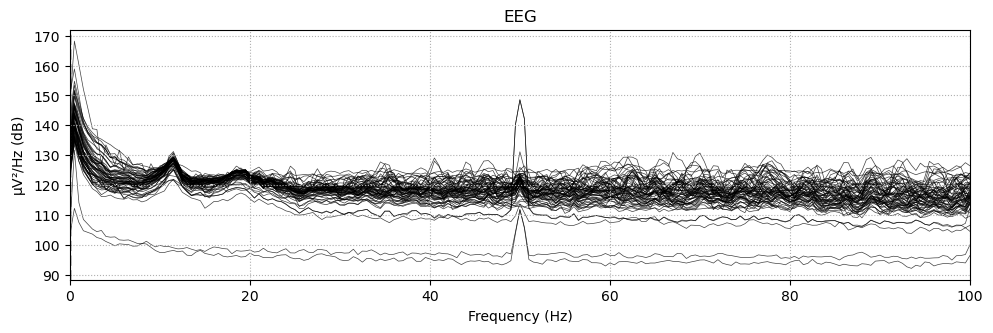

eyes open
Effective window size : 2.000 (s)


C:\Users\karul\AppData\Local\Temp\ipykernel_17104\2506176063.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  plot_raw_psd(raw_open, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 50 Hz


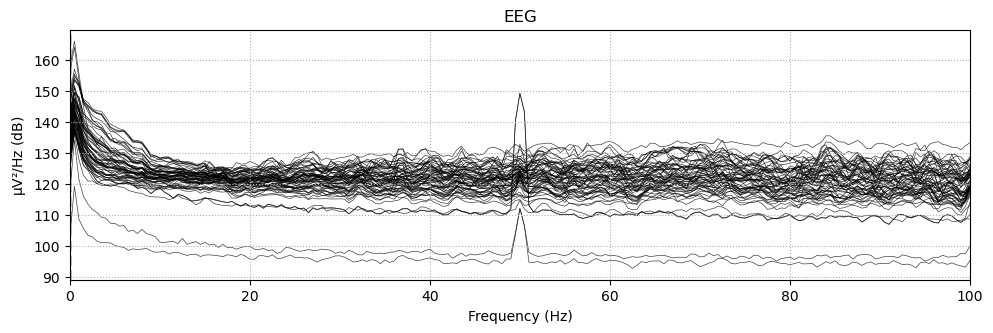

In [11]:
# plot raw psd using mne (seimicolon to only print one psd)
print("eyes closed")
plot_raw_psd(raw_closed, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 100 Hz

print("eyes open") 
plot_raw_psd(raw_open, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 100 Hz

In [7]:
# MNE Bandpassfilter all channels
import mne.filter 

# Set cutoffs for the filter
l_freq = 0.5 # Hz
h_freq = 40 # Hz

############################################ first eyes closed filtering ############################################
raw_closed_filt = raw_closed.copy()

#Create filter using iir and bandpass
iir_bw_filter_closed = mne.filter.create_filter(raw_closed_filt.get_data(), sfreq=fs, l_freq=l_freq, h_freq=h_freq, method='iir', verbose=False)

# Apply the filter values by convolve
raw_closed_filt = mne.filter.filter_data(raw_closed_filt.get_data(), sfreq=fs, l_freq=l_freq, h_freq=h_freq, method='iir',iir_params=iir_bw_filter_closed, verbose=False)
# output is a ndarray, so we need to convert it to a RawArray
raw_closed_filt = RawArray(raw_closed_filt, info)

# Display the eyes closed data as the 64 channels
#plot_raw(raw_closed_filt,title='RAW EEG eyes closed BW filtered',scalings ='auto') 

############################################ second eyes open filtering ############################################
raw_open_filt = raw_open.copy()

#Create filter using iir and bandpass
iir_bw_filter_open = mne.filter.create_filter(raw_open_filt.get_data(), sfreq=fs, l_freq=l_freq, h_freq=h_freq, method='iir', verbose=False)

# Apply the filter values by convolve
raw_open_filt = mne.filter.filter_data(raw_open_filt.get_data(), sfreq=fs, l_freq=l_freq, h_freq=h_freq, method='iir',iir_params=iir_bw_filter_open, verbose=False)

# output is a ndarray, so we need to convert it to a RawArray
raw_open_filt = RawArray(raw_open_filt, info)

# Display the eyes open data 
plot_raw(raw_open_filt,title='RAW EEG eyes open BW filtered',scalings ='auto')


Creating RawArray with float64 data, n_channels=64, n_times=123904
    Range : 0 ... 123903 =      0.000 ...   120.999 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=142336
    Range : 0 ... 142335 =      0.000 ...   138.999 secs
Ready.
Opening raw-browser...


eyes closed filtered
Effective window size : 2.000 (s)


C:\Users\karul\AppData\Local\Temp\ipykernel_17104\2125762134.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  plot_raw_psd(raw_closed_filt, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 50 Hz


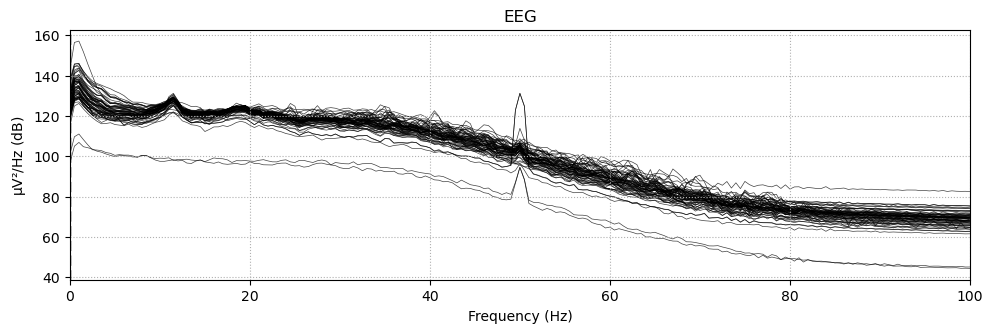

eyes open filtered
Effective window size : 2.000 (s)


C:\Users\karul\AppData\Local\Temp\ipykernel_17104\2125762134.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  plot_raw_psd(raw_open_filt, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 50 Hz


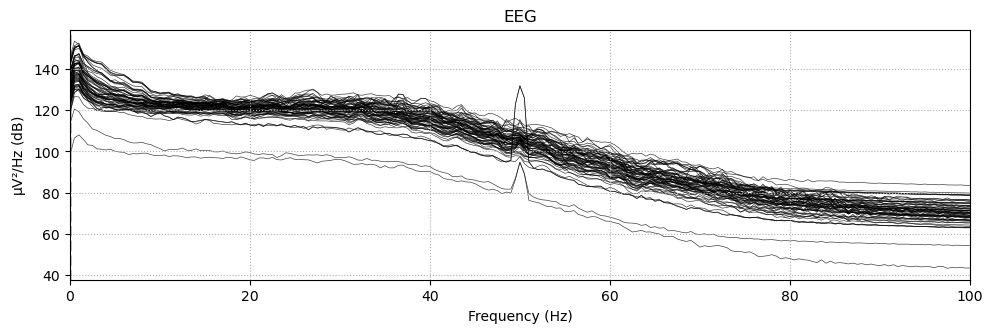

In [12]:
# plot raw psd using mne again after filtering
print("eyes closed filtered")
plot_raw_psd(raw_closed_filt, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 100 Hz

print("eyes open filtered")
plot_raw_psd(raw_open_filt, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 100 Hz

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hann window with 0.0546 passband ripple and 44 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6349 samples (6.200 sec)



c:\Users\karul\anaconda3\envs\bisiAI\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\Users\karul\anaconda3\envs\bisiAI\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\Users\karul\anaconda3\envs\bisiAI\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\Users\karul\anaconda3\envs\bisiAI\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hann window with 0.0546 passband ripple and 44 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6349 samples (6.200 sec)



c:\Users\karul\anaconda3\envs\bisiAI\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\Users\karul\anaconda3\envs\bisiAI\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\Users\karul\anaconda3\envs\bisiAI\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\Users\karul\anaconda3\envs\bisiAI\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


eyes closed filtered and notch filtered
Effective window size : 2.000 (s)


C:\Users\karul\AppData\Local\Temp\ipykernel_17104\53256387.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  plot_raw_psd(raw_closed_filt, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 100 Hz


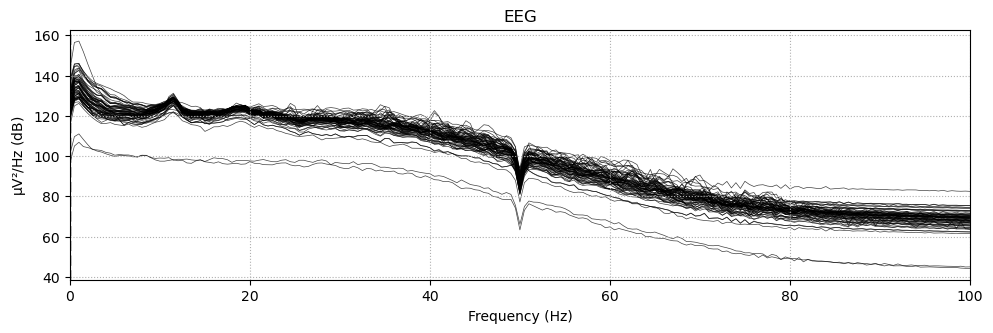

eyes open filtered and notch filtered
Effective window size : 2.000 (s)


C:\Users\karul\AppData\Local\Temp\ipykernel_17104\53256387.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  plot_raw_psd(raw_open_filt, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 100 Hz


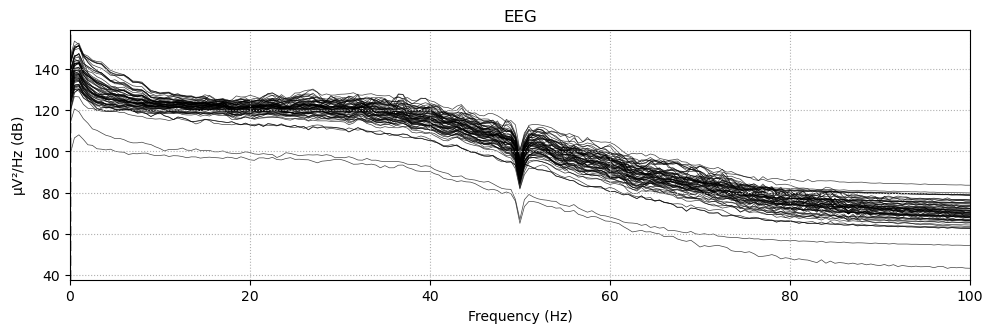

In [13]:
# From above power spectral density plots, we can see that the bandpass filter has removed the low frequency noise and high frequency noise from the data.
# The data still contains a 50 Hz noise, which is likely due to the power line noise. We can remove this noise by applying a notch filter.


#Remove 50 Hz noise and its higher harmonic 100Hz with a notch filter, width of 0.5 Hz. Zero phase shift. 
raw_closed_filt = raw_closed_filt.notch_filter([50, 100], notch_widths=0.5, filter_length='auto', phase='zero', fir_window='hann', fir_design='firwin', verbose=None)
raw_open_filt = raw_open_filt.notch_filter([50, 100], notch_widths=0.5, filter_length='auto', phase='zero', fir_window='hann', fir_design='firwin', verbose=None)
#notch_widths is the width of the stop band in Hz. The lower the value, the narrower the stop band.

# Display the psd of the filtered data again to see the effect of the notch filter
print("eyes closed filtered and notch filtered")
plot_raw_psd(raw_closed_filt, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 100 Hz

print("eyes open filtered and notch filtered")
plot_raw_psd(raw_open_filt, fmax=100); # plot the power spectral density of the raw data with a maximum frequency of 100 Hz






In [14]:
# Z-score normalization of the data after filtering with mean and std values for each channel

############################################ First eyes closed normalization ############################################
#Get data from the raw object
data_closed_filt = raw_closed_filt.get_data()

for i in range(64): # take the mean and std of each channel and normalize the data channel by channel
    data_closed_filt[i] = (data_closed_filt[i] - np.mean(data_closed_filt[i])) / np.std(data_closed_filt[i])
    
# Convert back to raw object
raw_closed_filt = RawArray(data_closed_filt, info)

# Display the eyes closed data 
# plot_raw(raw_closed_filt,title='RAW EEG eyes closed BW filtered and normalized',scalings ='auto')

############################################ Second eyes open normalization ############################################
#Get data from the raw object
data_open_filt = raw_open_filt.get_data()

for i in range(64):
    data_open_filt[i] = (data_open_filt[i] - np.mean(data_open_filt[i])) / np.std(data_open_filt[i])
    
# Convert back to raw object
raw_open_filt = RawArray(data_open_filt, info)

# Display the eyes open data
plot_raw(raw_open_filt,title='RAW EEG eyes open BW filtered and normalized',scalings ='auto')

Creating RawArray with float64 data, n_channels=64, n_times=123904
    Range : 0 ... 123903 =      0.000 ...   120.999 secs
Ready.


Creating RawArray with float64 data, n_channels=64, n_times=142336
    Range : 0 ... 142335 =      0.000 ...   138.999 secs
Ready.
Opening raw-browser...


In [15]:
# Remove 0.5 Seconds in the start and end of signal to remove filter artefacts
# Calculate tmax for the end of the closed eyes signal
tmax_closed = raw_closed_filt.times[-1] - 0.5 # 0.5 seconds from the end of the signal
raw_closed_filt.crop(tmin=0.5, tmax=tmax_closed) # crop both start and end of the signal with 0.5 seconds

# Calculate tmax for the end of the eyes open signal
tmax_open = raw_open_filt.times[-1] - 0.5 # 0.5 seconds from the end of the signal
raw_open_filt.crop(tmin=0.5, tmax=tmax_open) # crop both start and end of the signal with 0.5 seconds


<RawArray | 64 x 141312 (138.0 s), ~69.1 MB, data loaded>

In [37]:
#save the data as a new  file in the same folder
raw_open_filt.save('raw_open_preprocessed.fif', overwrite=True) #this has to be in fif format not edf or raw
raw_closed_filt.save('raw_closed_preprocessed.fif', overwrite=True) #this has to be in fif format not edf or raw
# in order to load in again use the function: mne.io.read_raw_fif('pre_processed.fif', preload=True)
############################################################

Writing c:\Users\karul\Desktop\Kandidat\Udveksling\1. Bioinstrumentation\Project\raw_open_preprocessed.fif
Closing c:\Users\karul\Desktop\Kandidat\Udveksling\1. Bioinstrumentation\Project\raw_open_preprocessed.fif
[done]
Writing c:\Users\karul\Desktop\Kandidat\Udveksling\1. Bioinstrumentation\Project\raw_closed_preprocessed.fif
Closing c:\Users\karul\Desktop\Kandidat\Udveksling\1. Bioinstrumentation\Project\raw_closed_preprocessed.fif


C:\Users\karul\AppData\Local\Temp\ipykernel_17104\812246160.py:2: RuntimeWarning: This filename (c:\Users\karul\Desktop\Kandidat\Udveksling\1. Bioinstrumentation\Project\raw_open_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_open_filt.save('raw_open_preprocessed.fif', overwrite=True) #this has to be in fif format not edf or raw
C:\Users\karul\AppData\Local\Temp\ipykernel_17104\812246160.py:3: RuntimeWarning: This filename (c:\Users\karul\Desktop\Kandidat\Udveksling\1. Bioinstrumentation\Project\raw_closed_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_closed_filt.save('raw_closed_prep

[done]


In [17]:
# Load the saved data
import mne
from mne import create_info
from mne.io import RawArray
from mne.viz import plot_raw
raw_open_filt = mne.io.read_raw_fif('raw_open_preprocessed.fif', preload=True)
raw_closed_filt = mne.io.read_raw_fif('raw_closed_preprocessed.fif', preload=True)

# Load the channels and stuff for the info again
channels = pd.read_csv("channel_names.csv", names = ['names'])
new_names = channels['names'].to_list()
ch_types = ['eeg'] * 64
fs = 1024
info = create_info(ch_names=new_names, sfreq=fs, ch_types=ch_types)

# plot the two signals to see the effect of the preprocessing and the starting point using mne
plot_raw(raw_closed_filt,title='RAW EEG eyes closed BW filtered, normalized and cropped',scalings ='auto')
#plot_raw(raw_open_filt,title='RAW EEG eyes open BW filtered, normalized and cropped',scalings ='auto')


Opening raw data file raw_open_preprocessed.fif...
Isotrak not found
    Range : 512 ... 141823 =      0.500 ...   138.499 secs
Ready.
Reading 0 ... 141311  =      0.000 ...   137.999 secs...
Opening raw data file raw_closed_preprocessed.fif...
Isotrak not found
    Range : 512 ... 123391 =      0.500 ...   120.499 secs
Ready.
Reading 0 ... 122879  =      0.000 ...   119.999 secs...


C:\Users\karul\AppData\Local\Temp\ipykernel_38728\1873343861.py:6: RuntimeWarning: This filename (raw_open_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_open_filt = mne.io.read_raw_fif('raw_open_preprocessed.fif', preload=True)
C:\Users\karul\AppData\Local\Temp\ipykernel_38728\1873343861.py:7: RuntimeWarning: This filename (raw_closed_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_closed_filt = mne.io.read_raw_fif('raw_closed_preprocessed.fif', preload=True)


Opening raw-browser...


<font size=5 color=#009999> <b> CONSTRUCT YOUR TRAINING SAMPLES </b> <br>
DIVIDE THE SIGNALS INTO SHORT SEGMENTS
</font> <br> <br>

One segment should correspond to a signal recorded either in eyes open or eyes closed condition. <br>

 
   
<div class="alert alert-info">
<b>[Question 3] Segment your data </b>  <br>
Segment the entire time signal into short segments of 500 ms. Each segment will constitue one training/validation/test sample of your final dataset. <br>
Is it interresting to consider overlapping segments, i.e. a first segments ranging between [1.5s,2s] and a second ranging between [1.75s,2.25s]? 
</div> 

In [30]:
#  0.25 overlap (50%) between segments for the dataset of window length 500ms. 
# Get data
data_closed_filt = raw_closed_filt.get_data()
data_open_filt = raw_open_filt.get_data()

# Create epochs of 500ms with 0.5 overlap for eyes closed
epochs_closed = mne.make_fixed_length_epochs(raw_closed_filt, duration=0.5, overlap=0.25)
epochs_open = mne.make_fixed_length_epochs(raw_open_filt, duration=0.5, overlap=0.25)
# When overlap is set to 0.5, the epochs are non-overlapping, so to get 50% overlap, set it to 0.25

# Get data from the epochs
data_closed_epochs = epochs_closed.get_data()
data_open_epochs = epochs_open.get_data()


Not setting metadata
479 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
551 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 479 events and 512 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 551 events and 512 original time points ...
0 bad epochs dropped


In [42]:
# Save the segmented eyes closed data in a pickle file 
import pickle
with open('data_closed_eyes_epochs.pickle', 'wb') as f:
    pickle.dump(data_closed_epochs, f)
    
# Save the segmented eyes open data in a pickle file
with open('data_open_eyes_epochs.pickle', 'wb') as f:
    pickle.dump(data_open_epochs, f)

In [1]:
################################################# Load script from here to calculate features #################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pickle
import mne
from mne.viz import plot_raw
# open the pickle file and load the data
with open('data_closed_eyes_epochs.pickle', 'rb') as f:
    data_closed_epochs = pickle.load(f)

with open('data_open_eyes_epochs.pickle', 'rb') as f:
    data_open_epochs = pickle.load(f)
 
# Set the fs again if loaded from pickle
fs = 1024


# Also Load the saved data
raw_open_filt = mne.io.read_raw_fif('raw_open_preprocessed.fif', preload=True)
raw_closed_filt = mne.io.read_raw_fif('raw_closed_preprocessed.fif', preload=True)

# plot the two signals to see the effect of the preprocessing and the starting point using mne
plot_raw(raw_closed_filt,title='RAW EEG eyes closed BW filtered, normalized and cropped',scalings ='auto')
plot_raw(raw_open_filt,title='RAW EEG eyes open BW filtered, normalized and cropped',scalings ='auto')


Opening raw data file raw_open_preprocessed.fif...
Isotrak not found
    Range : 512 ... 141823 =      0.500 ...   138.499 secs
Ready.


C:\Users\karul\AppData\Local\Temp\ipykernel_26016\1353239241.py:21: RuntimeWarning: This filename (raw_open_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_open_filt = mne.io.read_raw_fif('raw_open_preprocessed.fif', preload=True)


Reading 0 ... 141311  =      0.000 ...   137.999 secs...
Opening raw data file raw_closed_preprocessed.fif...
Isotrak not found
    Range : 512 ... 123391 =      0.500 ...   120.499 secs
Ready.
Reading 0 ... 122879  =      0.000 ...   119.999 secs...


C:\Users\karul\AppData\Local\Temp\ipykernel_26016\1353239241.py:22: RuntimeWarning: This filename (raw_closed_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_closed_filt = mne.io.read_raw_fif('raw_closed_preprocessed.fif', preload=True)


Using qt as 2D backend.
Opening raw-browser...
Opening raw-browser...


<br><br>

<font size=6 color=#009999> <center><b>PART II - FEATURE GENERATION </b></center> </font> <br> <br>

<font size=5 color=#009999> <b>CREATE YOUR OWN FEATURE SPACE </b> <br>
WHAT CAN BE CONSIDERED?
</font> <br> <br>

To be able to classify your EEG segments, you must define the features on which you will apply the classification algorithms. These features should somehow summarize as best as possible the ‘useful’ information contained in an EEG segment.<br>

A first option is to consider the power of the channels in different physiological frequency bands. In this case, you will have $n\_chan \times n\_freq$ features, where $n\_chan$ is the number of channels (here 64) and $n\_freq$ is the number of frequency bands considered. Does such features make sense in this project?
   
<b>Feel free to consider different features as well. Do not forget to give and comment their definition in the report.</b>

<div class="alert alert-warning">
<b>Power of a frequency band </b>  <br>
We provide you the <samp>getBandPower</samp> function which should help you to compute the power of several frequency bands (defined randomly). Do not hesitate to rely on this function to get your feature space.
</div> 

<div class="alert alert-info">
<b>[Question 4] Create your feature space </b>  <br>
Explain your methodology to create relevant features out of the segments you have obtained before. You may consider the the power of a relevant subset of the channels in different physiological frequency bands. <br>
Can you provide example of other relevant features? 
</div> 

In [2]:
# Calculate the band power for each epoch and each channel
 
import scipy.signal as signal
from scipy.integrate import simps
from scipy.signal import welch

# -------------------------------------------------------------------------------------
# Provide the PSD of a signal for several frequency bands 
# Inspired from the tutorial : https://raphaelvallat.com/bandpower.html
# Inputs : 
#   - signal : a 1-D signal 
#   - fs : sampling frequency of the signal
# Outputs: 
#   - PSD : a list of the PSD evaluated in the specified frequency bands
#   - rangeName : a list describing the frequency bands in brainwaves
#   - brainwave bands: Delta: 0.5-4 Hz, Theta: 4-8 Hz, Alpha: 8-12 Hz, Beta: 12-30 Hz, Gamma: 30-40 Hz (but since we bandpass filtered the data, we will only consider up to 40 Hz)
# -------------------------------------------------------------------------------------
def getBandPower(signal, fs): 
    freqs, psd  = welch(signal, fs, nfft = 8192)
    freq_res    = freqs[1] - freqs[0]
    total_power = simps(psd, dx=freq_res)

    freqRanges = [[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 40]] 
    rangeName  = ['Delta', 'Theta', 'Alpha', 'Beta','Gamma']  
    power_spectra_density        = []
    for thisRange in freqRanges: 
        low, high = thisRange[0], thisRange[1]
        idx       = np.logical_and(freqs >= low, freqs <= high) 
        power_spectra_density.append(simps(psd[idx], dx=freq_res) / total_power)
    return power_spectra_density, rangeName


# Constants
n_channels = 64 
n_epochs_closed = len(data_closed_epochs)
n_epochs_open = len(data_open_epochs)
n_bands = 5 # ['Delta', 'Theta', 'Alpha', 'Beta','Gamma']  

# Empty arrays to store the band power values
band_power_closed = np.zeros((n_channels, n_epochs_closed, n_bands))
band_power_open = np.zeros((n_channels, n_epochs_open, n_bands))

# Calculate the band power for each epoch and each channel
for i in range(n_channels):
    for j in range(n_epochs_closed):
        band_power_closed[i, j, :], _ = getBandPower(data_closed_epochs[j, i], fs)
        
    for j in range(n_epochs_open):
        band_power_open[i, j, :], _ = getBandPower(data_open_epochs[j, i], fs)

# Calculate the mean band power for each channel
mean_band_power_closed = np.mean(band_power_closed, axis=1)
mean_band_power_open = np.mean(band_power_open, axis=1)

#Takes 43 seconds to run

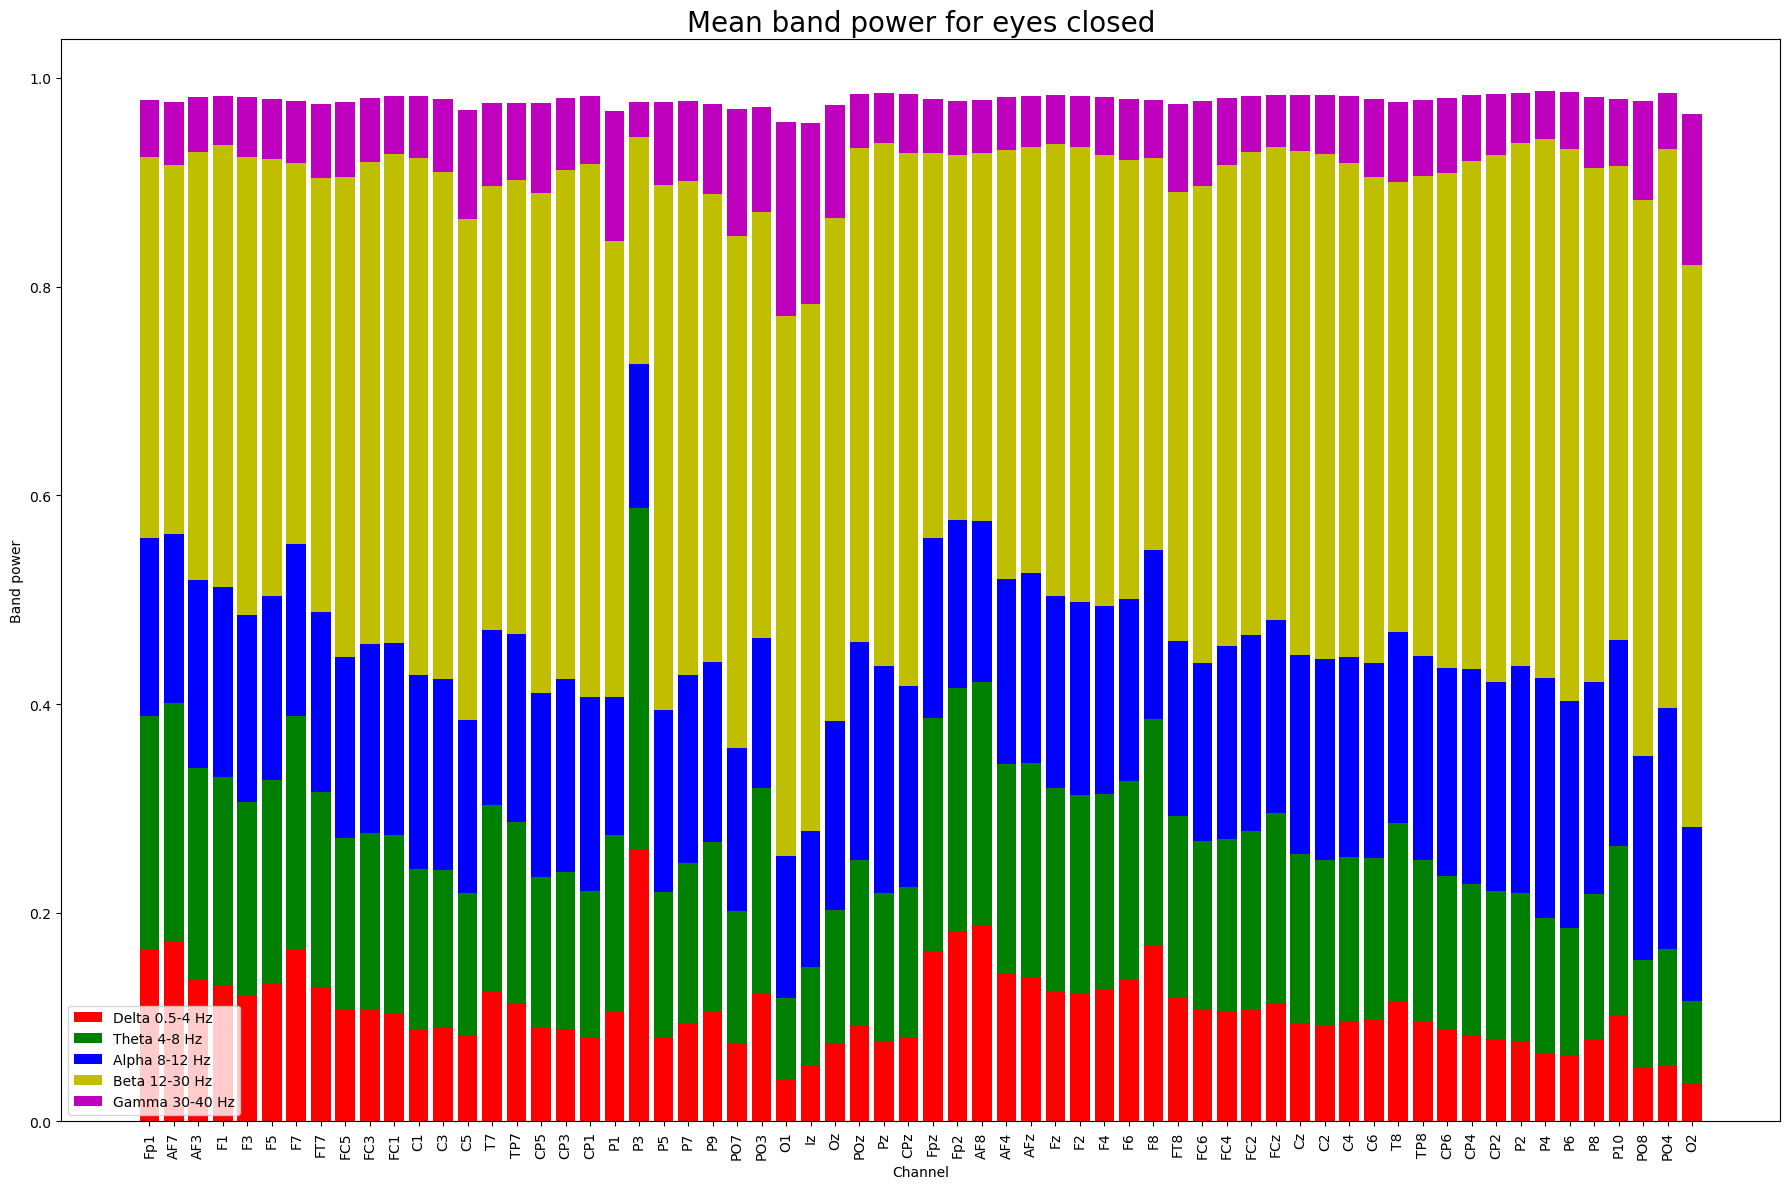

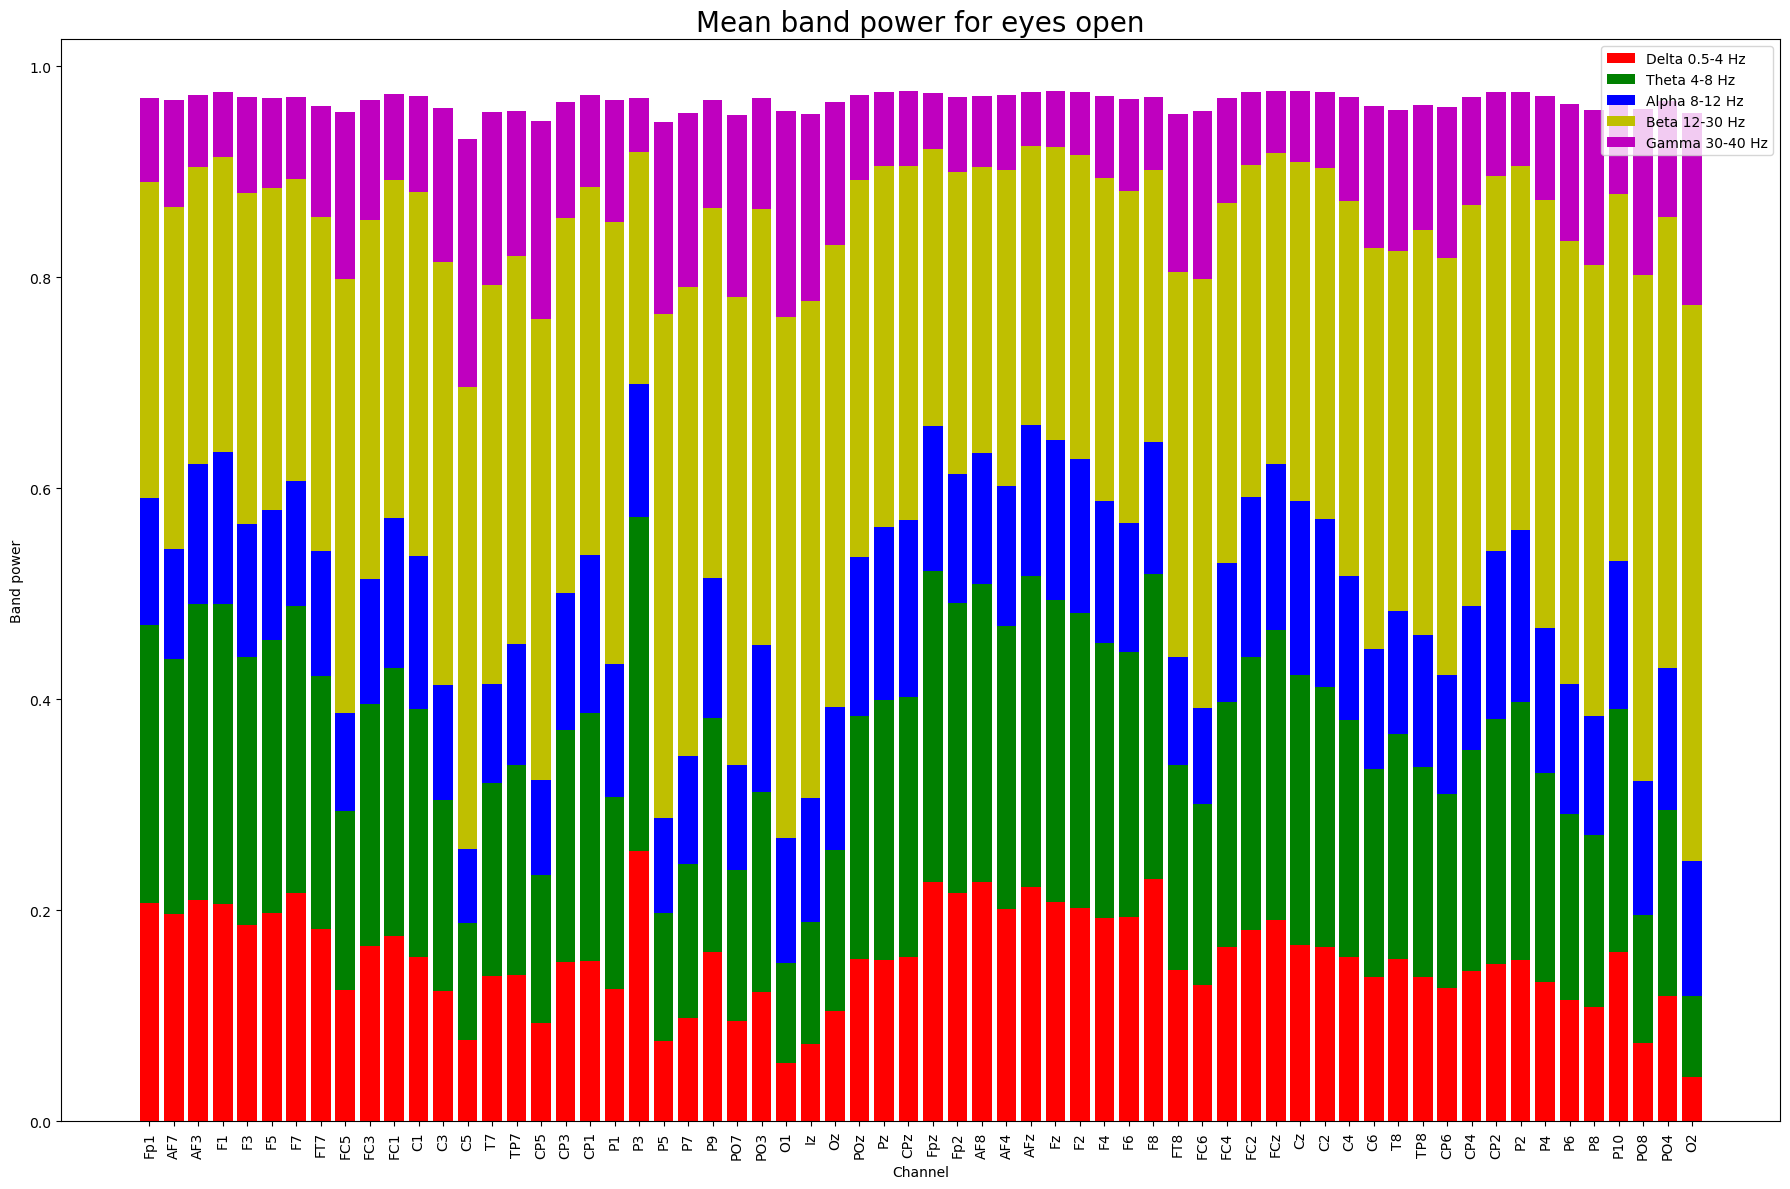

In [12]:
# Bar Plot the mean band power for each channel
plt.figure(figsize=(18,12))
plt.bar(raw_closed_filt.ch_names, mean_band_power_closed[:, 0], color='r', label='Delta 0.5-4 Hz')
plt.bar(raw_closed_filt.ch_names, mean_band_power_closed[:, 1], color='g', label='Theta 4-8 Hz', bottom=mean_band_power_closed[:, 0])
plt.bar(raw_closed_filt.ch_names, mean_band_power_closed[:, 2], color='b', label='Alpha 8-12 Hz', bottom=mean_band_power_closed[:, 0] + mean_band_power_closed[:, 1])
plt.bar(raw_closed_filt.ch_names, mean_band_power_closed[:, 3], color='y', label='Beta 12-30 Hz', bottom=mean_band_power_closed[:, 0] + mean_band_power_closed[:, 1] + mean_band_power_closed[:, 2])
plt.bar(raw_closed_filt.ch_names, mean_band_power_closed[:, 4], color='m', label='Gamma 30-40 Hz', bottom=mean_band_power_closed[:, 0] + mean_band_power_closed[:, 1] + mean_band_power_closed[:, 2] + mean_band_power_closed[:, 3])
plt.title('Mean band power for eyes closed', fontsize=20)
plt.xlabel('Channel')
plt.ylabel('Band power')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()  # Adjust to fit into the figure area
plt.show()

# Bar plot the mean band power for eyes open
plt.figure(figsize=(18,12))
plt.bar(raw_open_filt.ch_names, mean_band_power_open[:, 0], color='r', label='Delta 0.5-4 Hz')
plt.bar(raw_open_filt.ch_names, mean_band_power_open[:, 1], color='g', label='Theta 4-8 Hz', bottom=mean_band_power_open[:, 0])
plt.bar(raw_open_filt.ch_names, mean_band_power_open[:, 2], color='b', label='Alpha 8-12 Hz', bottom=mean_band_power_open[:, 0] + mean_band_power_open[:, 1])
plt.bar(raw_open_filt.ch_names, mean_band_power_open[:, 3], color='y', label='Beta 12-30 Hz', bottom=mean_band_power_open[:, 0] + mean_band_power_open[:, 1] + mean_band_power_open[:, 2])
plt.bar(raw_open_filt.ch_names, mean_band_power_open[:, 4], color='m', label='Gamma 30-40 Hz', bottom=mean_band_power_open[:, 0] + mean_band_power_open[:, 1] + mean_band_power_open[:, 2] + mean_band_power_open[:, 3])
plt.title('Mean band power for eyes open', fontsize=20)
plt.xlabel('Channel')
plt.ylabel('Band power')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()  # Adjust to fit into the figure area
plt.show()

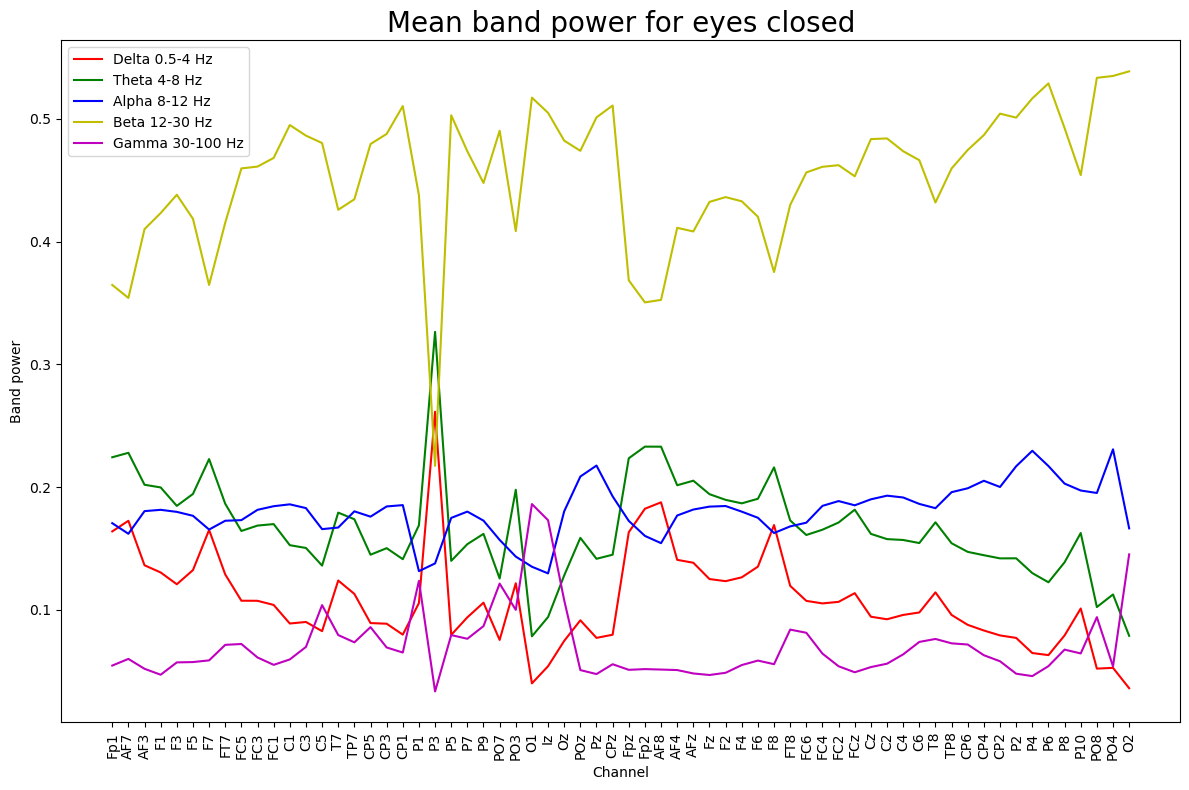

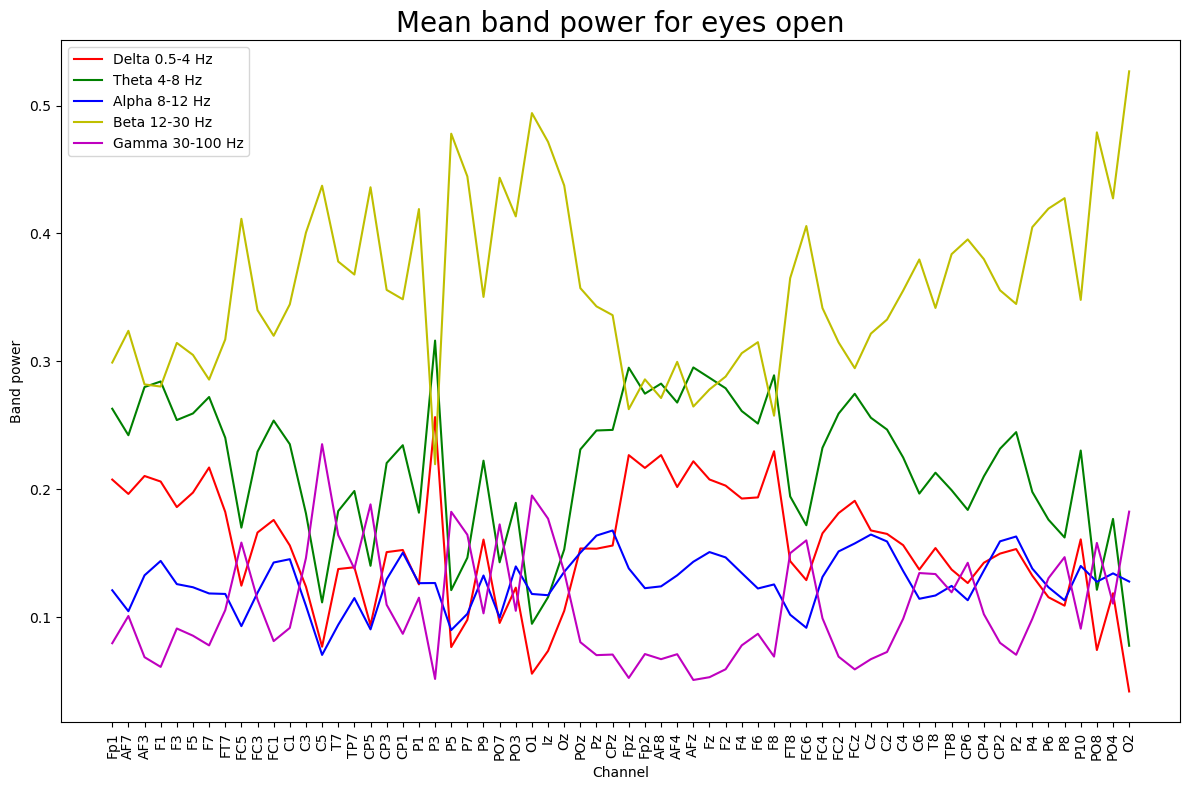

In [13]:
# Plot the mean band power for each channel closed eyes as line plot instead of bar plot
plt.figure(figsize=(12,8))
for i, (band, color) in enumerate(zip(['Delta 0.5-4 Hz', 'Theta 4-8 Hz', 'Alpha 8-12 Hz', 'Beta 12-30 Hz', 'Gamma 30-100 Hz'], ['r', 'g', 'b', 'y', 'm'])):
    plt.plot(raw_closed_filt.ch_names, mean_band_power_closed[:, i], color=color, label=band)
plt.title('Mean band power for eyes closed', fontsize=20)
plt.xlabel('Channel')
plt.ylabel('Band power')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()  # Adjust to fit into the figure area
plt.show()

# plot the mean band power for eyes open
plt.figure(figsize=(12,8))
for i, (band, color) in enumerate(zip(['Delta 0.5-4 Hz', 'Theta 4-8 Hz', 'Alpha 8-12 Hz', 'Beta 12-30 Hz', 'Gamma 30-100 Hz'], ['r', 'g', 'b', 'y', 'm'])):
    plt.plot(raw_open_filt.ch_names, mean_band_power_open[:, i], color=color, label=band)
plt.title('Mean band power for eyes open', fontsize=20)
plt.xlabel('Channel')
plt.ylabel('Band power')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()  # Adjust to fit into the figure area
plt.show()

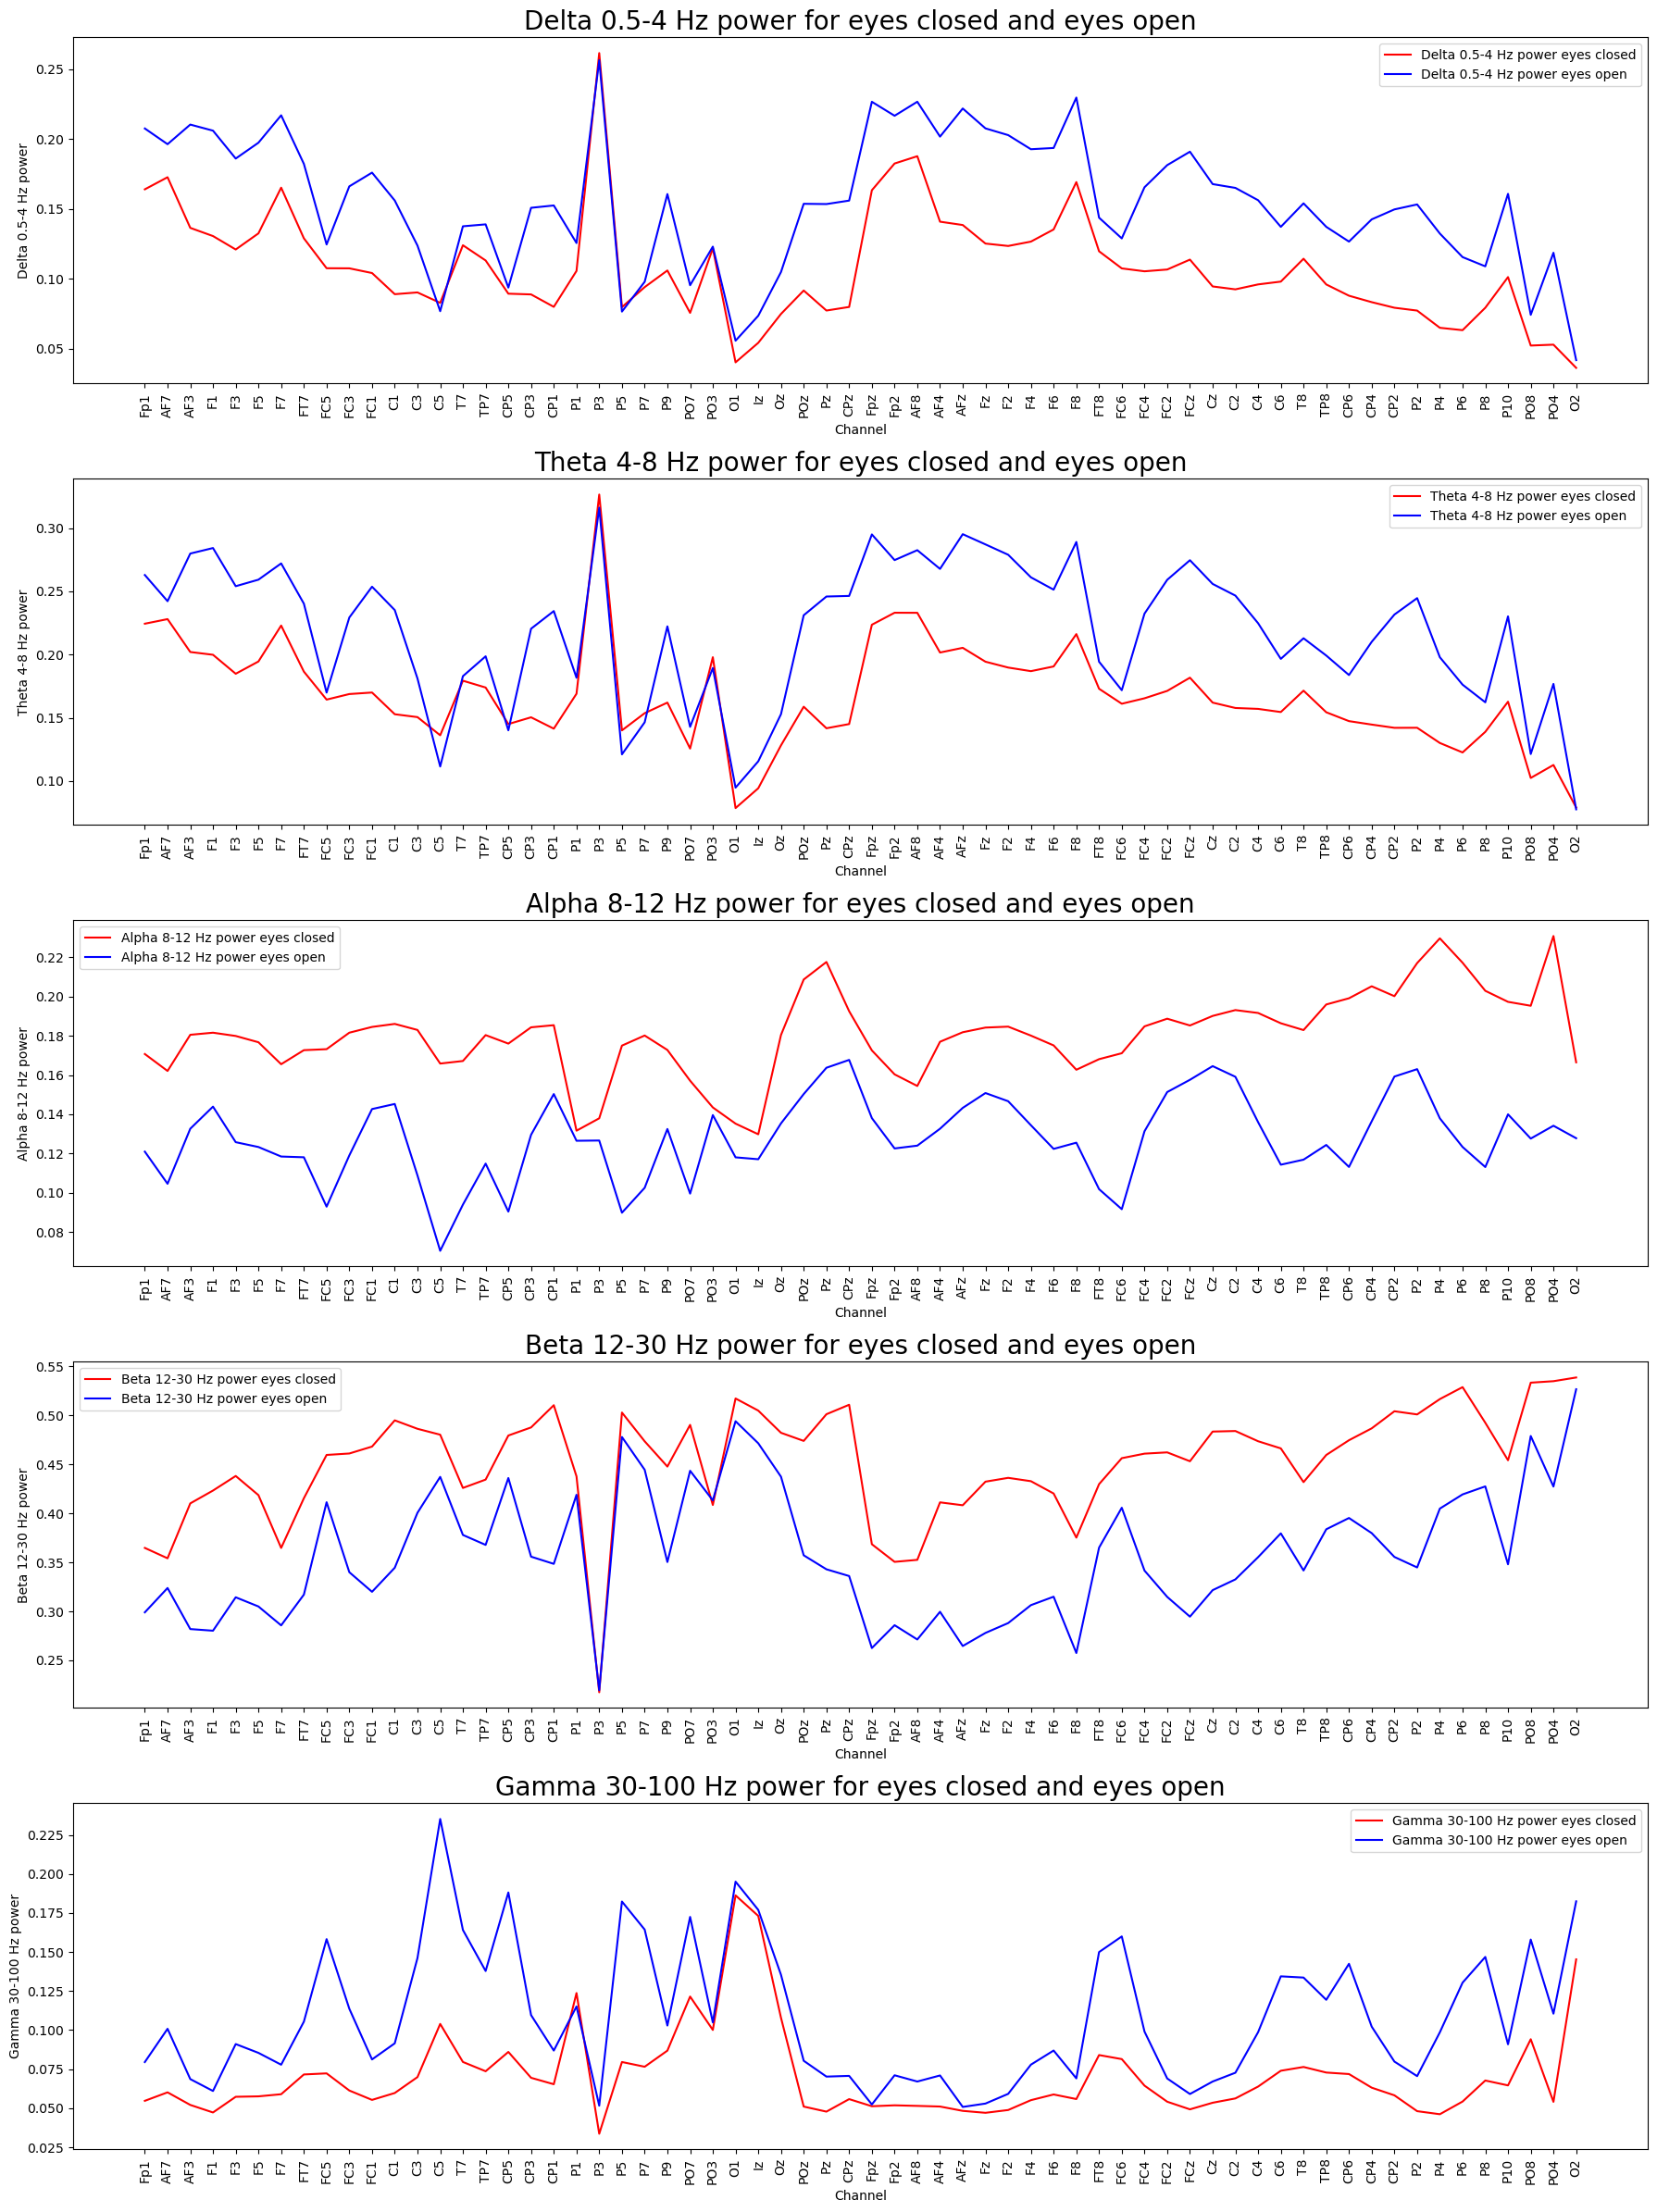

In [14]:
# Subplots for each band power between eyes closed and eyes open datasets
fig, axs = plt.subplots(5, figsize=(18,24))

# Define band names and their indices
bands = ['Delta 0.5-4 Hz', 'Theta 4-8 Hz', 'Alpha 8-12 Hz', 'Beta 12-30 Hz', 'Gamma 30-100 Hz']
indices = [0, 1, 2, 3, 4]

# Loop over each band
for ax, band, index in zip(axs, bands, indices):
    # Compare and plot the band power between eyes closed and eyes open
    band_closed = mean_band_power_closed[:, index]
    band_open = mean_band_power_open[:, index]
    ax.plot(raw_closed_filt.ch_names, band_closed, 'r', label=f'{band} power eyes closed')
    ax.plot(raw_open_filt.ch_names, band_open, 'b', label=f'{band} power eyes open')
    ax.set_title(f'{band} power for eyes closed and eyes open', fontsize=20)
    ax.set_xlabel('Channel')
    ax.set_ylabel(f'{band} power')
    ax.xaxis.set_tick_params(rotation=90)  # Rotate x-axis labels
    ax.legend()

# Adjust to fit into the figure area
plt.tight_layout()
plt.savefig('band_power_comparison.png')
plt.show()

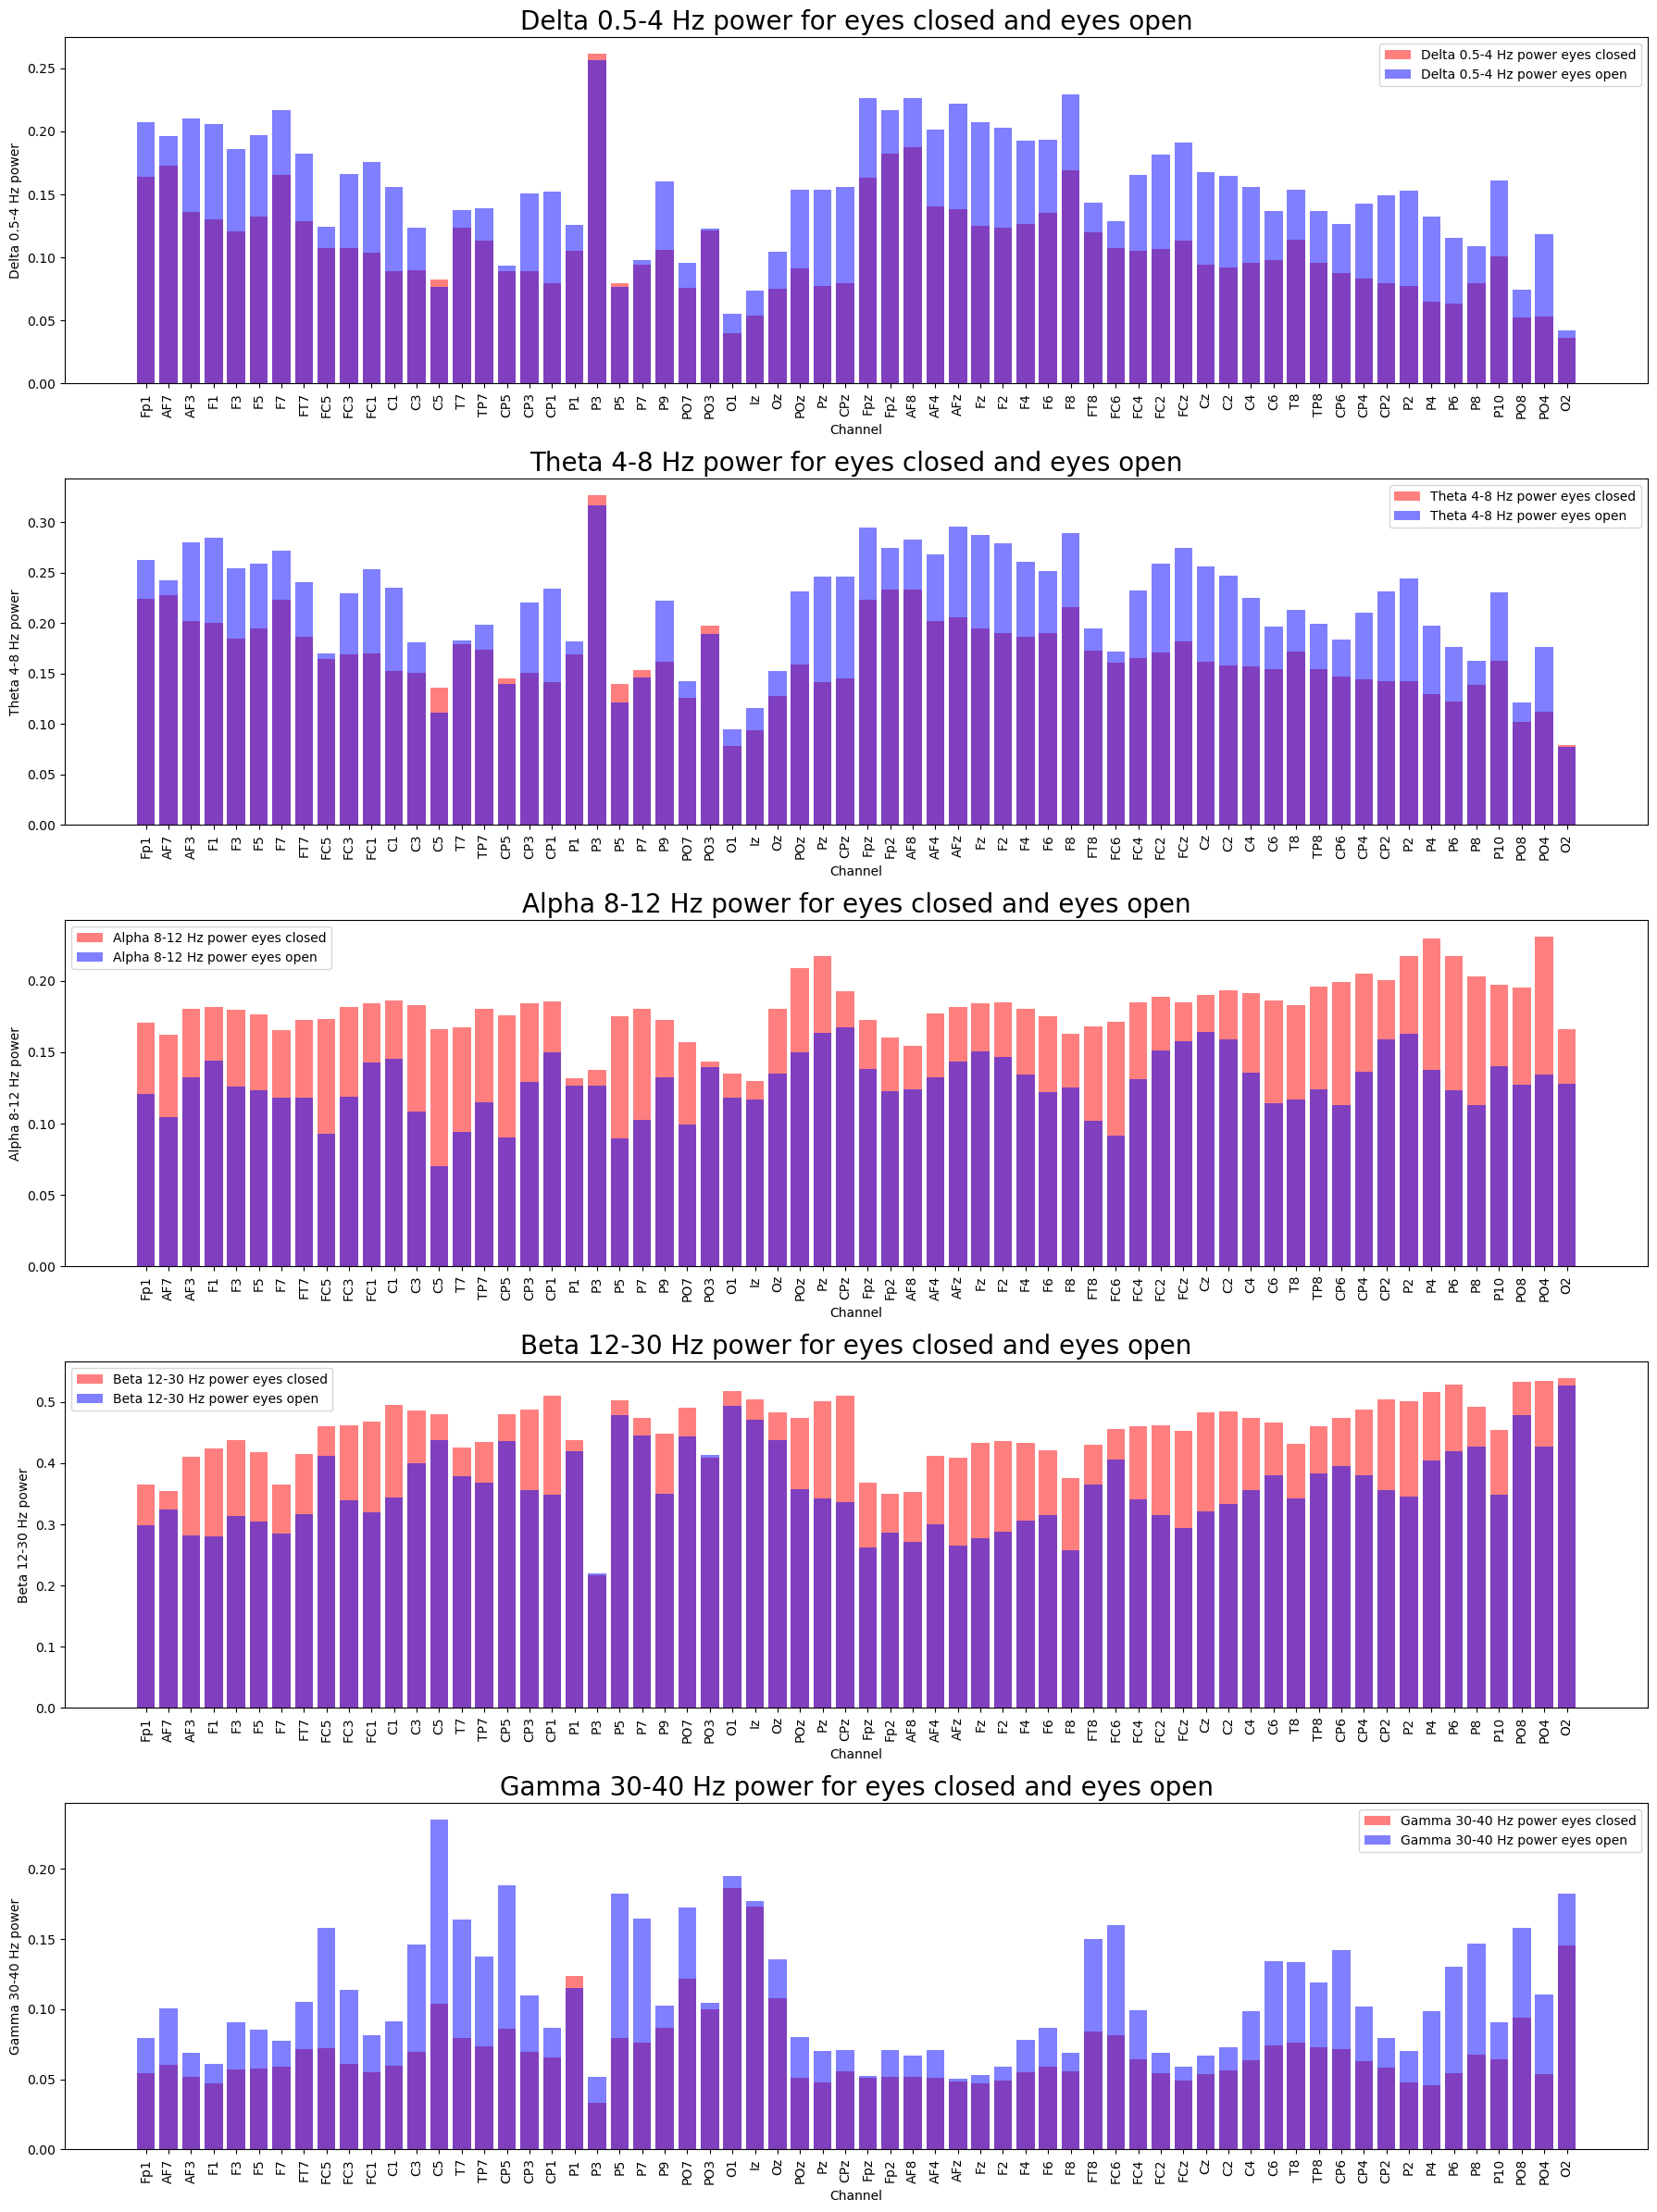

In [3]:
#Subplot the power bands to compare as a bar chart between eyes closed and eyes open
fig, axs = plt.subplots(5, figsize=(18,24))

# Define band names and their indices
bands = ['Delta 0.5-4 Hz', 'Theta 4-8 Hz', 'Alpha 8-12 Hz', 'Beta 12-30 Hz', 'Gamma 30-40 Hz']
indices = [0, 1, 2, 3, 4]

# Make transparency for the bars
alpha = 0.5

# Loop over each band
for ax, band, index in zip(axs, bands, indices):
    # Compare and plot the band power between eyes closed and eyes open
    band_closed = mean_band_power_closed[:, index]
    band_open = mean_band_power_open[:, index]
    ax.bar(raw_closed_filt.ch_names, band_closed, color='r', alpha=alpha, label=f'{band} power eyes closed')
    ax.bar(raw_open_filt.ch_names, band_open, color='b', alpha=alpha, label=f'{band} power eyes open')
    ax.set_title(f'{band} power for eyes closed and eyes open', fontsize=20)
    ax.set_xlabel('Channel')
    ax.set_ylabel(f'{band} power')
    ax.xaxis.set_tick_params(rotation=90)  # Rotate x-axis labels
    ax.legend()
    
# Adjust to fit into the figure area
plt.tight_layout()
plt.savefig('band_power_comparison_bar.png')
plt.show()


In [17]:
# Calculate power ratios for each band for each epoch for eyes closed and eyes open
# 5 ratios: Theta/Delta, Alpha/Theta, Beta/Alpha, Gamma/Beta and (Theta + delta)/(Alpha + Beta)

# Initialize the power ratios arrays
power_ratios_closed = np.zeros((n_channels, n_epochs_closed, 5))
power_ratios_open = np.zeros((n_channels, n_epochs_open, 5))

# Calculate the power ratios for each epoch and each channel
for i in range(n_channels):
    for j in range(n_epochs_closed):
        power_ratios_closed[i, j, 0] = mean_band_power_closed[i, 1] / mean_band_power_closed[i, 0]  # Theta/Delta
        power_ratios_closed[i, j, 1] = mean_band_power_closed[i, 2] / mean_band_power_closed[i, 1]  # Alpha/Theta
        power_ratios_closed[i, j, 2] = mean_band_power_closed[i, 3] / mean_band_power_closed[i, 2]  # Beta/Alpha
        power_ratios_closed[i, j, 3] = mean_band_power_closed[i, 4] / mean_band_power_closed[i, 3]  # Gamma/Beta
        power_ratios_closed[i, j, 4] = (mean_band_power_closed[i, 0] + mean_band_power_closed[i, 1]) / (mean_band_power_closed[i, 2] + mean_band_power_closed[i, 3])  # (Theta + delta)/(Alpha + Beta)
        
    for j in range(n_epochs_open):
        power_ratios_open[i, j, 0] = mean_band_power_open[i, 1] / mean_band_power_open[i, 0]  # Theta/Delta
        power_ratios_open[i, j, 1] = mean_band_power_open[i, 2] / mean_band_power_open[i, 1]  # Alpha/Theta
        power_ratios_open[i, j, 2] = mean_band_power_open[i, 3] / mean_band_power_open[i, 2]  # Beta/Alpha
        power_ratios_open[i, j, 3] = mean_band_power_open[i, 4] / mean_band_power_open[i, 3]  # Gamma/Beta
        power_ratios_open[i, j, 4] = (mean_band_power_open[i, 0] + mean_band_power_open[i, 1]) / (mean_band_power_open[i, 2] + mean_band_power_open[i, 3])  # (Theta + delta)/(Alpha + Beta)

# Calculate the mean power ratios for each channel
mean_power_ratios_closed = np.mean(power_ratios_closed, axis=1)
mean_power_ratios_open = np.mean(power_ratios_open, axis=1)


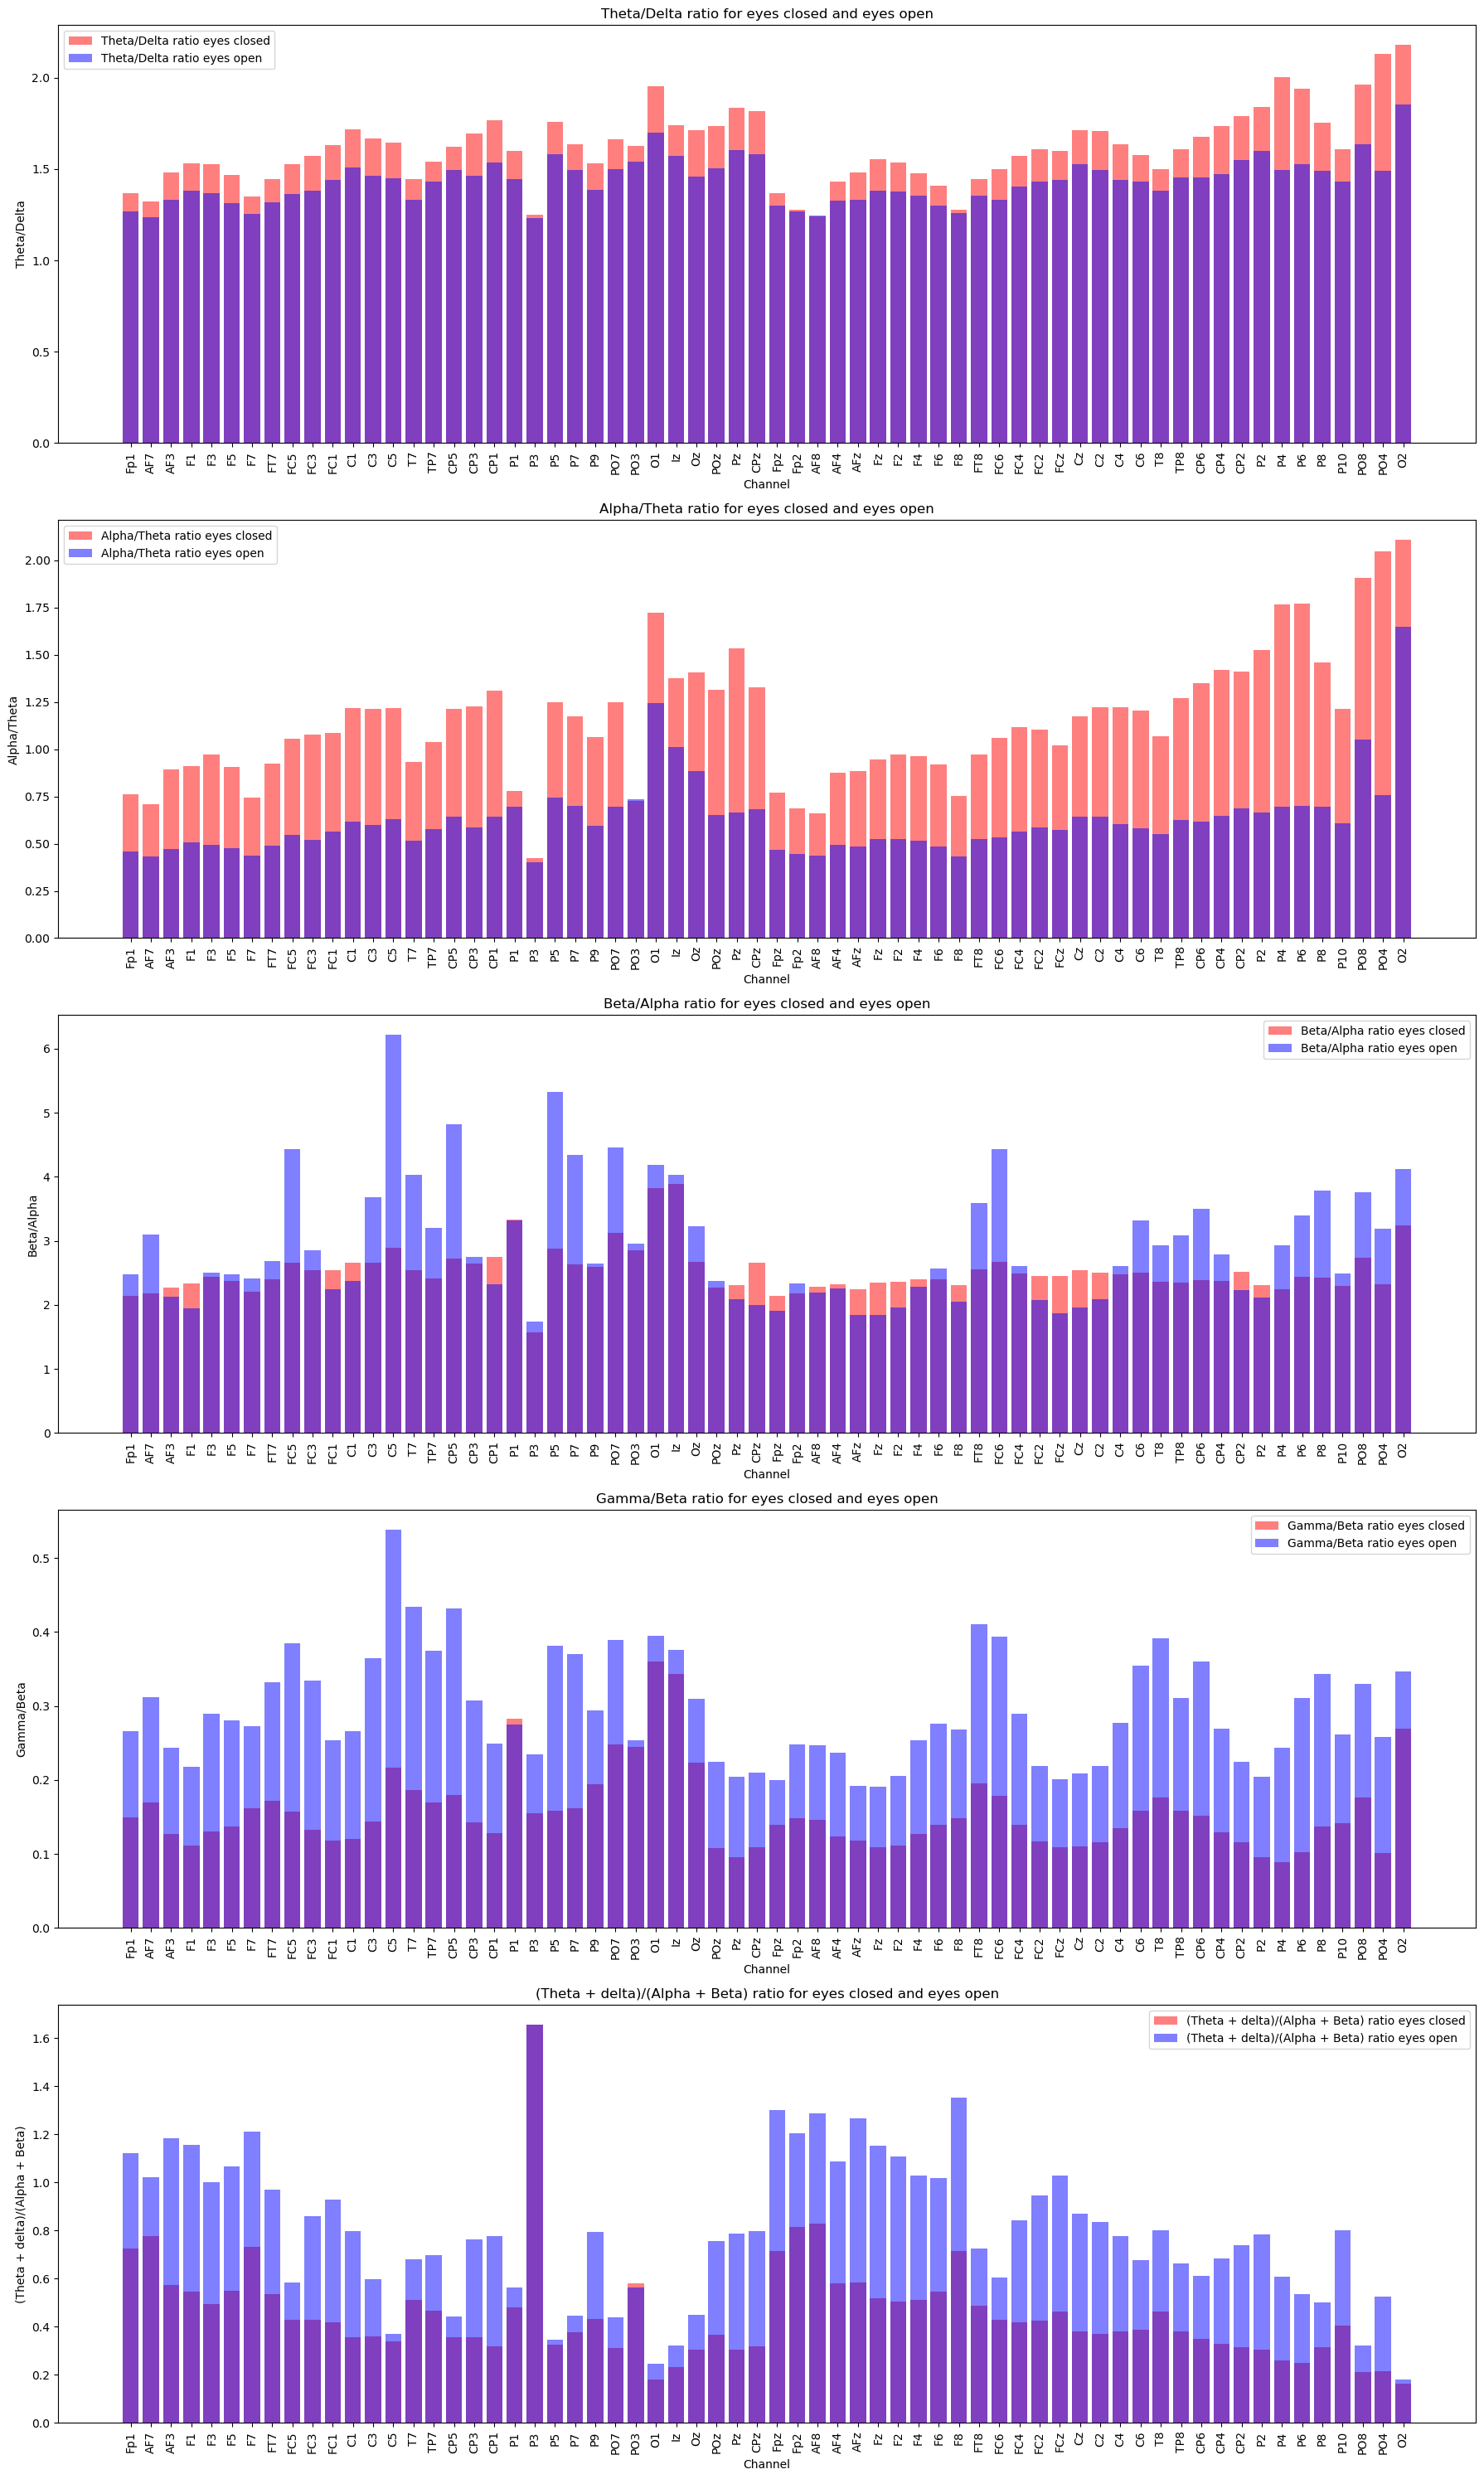

In [18]:
# Bar plot subplots to compare each power ratio between eyes closed and eyes open datasets
fig, axs = plt.subplots(5, figsize=(18,30))

# Define power ratio names and their indices
ratios = ['Theta/Delta', 'Alpha/Theta', 'Beta/Alpha', 'Gamma/Beta', '(Theta + delta)/(Alpha + Beta)']
indices = [0, 1, 2, 3, 4]

# Loop over each power ratio, zip is used to iterate over two lists in parallel
for ax, ratio, index in zip(axs, ratios, indices): 
    ratio_closed = mean_power_ratios_closed[:, index]
    ratio_open = mean_power_ratios_open[:, index]
    ax.bar(raw_closed_filt.ch_names, ratio_closed, color='r', alpha=0.5, label=f'{ratio} ratio eyes closed') # Alpha adds transparency to the bars to see overlapping bars
    ax.bar(raw_open_filt.ch_names, ratio_open, color='b', alpha=0.5, label=f'{ratio} ratio eyes open')
    ax.set_title(f'{ratio} ratio for eyes closed and eyes open', fontsize=12)
    ax.set_xlabel('Channel')
    ax.set_ylabel(f'{ratio}')
    ax.xaxis.set_tick_params(rotation=90)  # Rotate x-axis labels
    ax.legend()

# Adjust to fit into the figure area
plt.tight_layout()
plt.savefig('power_ratio_comparison.png')
plt.show()


In [ ]:
# Calculate the variance and standard deviation  of the 5 bands for each epoch and each channel for eyes closed and eyes open
import scipy.stats as stats

# Initialize arrays
std_band_power_closed = np.zeros((n_channels, n_epochs_closed, n_bands))
var_band_power_closed = np.zeros((n_channels, n_epochs_closed, n_bands))
std_band_power_open = np.zeros((n_channels, n_epochs_open, n_bands))
var_band_power_open = np.zeros((n_channels, n_epochs_open, n_bands))

# Calculate standard deviation and variance for each channel and band
for i in range(n_channels):
    for b in range(n_bands):
        std_band_power_closed[i, :, b] = np.std(band_power_closed[i, :, b], axis=0)
        var_band_power_closed[i, :, b] = np.var(band_power_closed[i, :, b], axis=0)
        std_band_power_open[i, :, b] = np.std(band_power_open[i, :, b], axis=0)
        var_band_power_open[i, :, b] = np.var(band_power_open[i, :, b], axis=0)

print("Shape of std band power closed:", std_band_power_closed.shape)
print("Shape variance of band power closed:", var_band_power_closed.shape)
print("Shape of std band power open:", std_band_power_open.shape)
print("Shape variance of band power open:", var_band_power_open.shape)


Shape of std band power closed: (64, 479, 5)
Shape variance of band power closed: (64, 479, 5)
Shape of std band power open: (64, 551, 5)
Shape variance of band power open: (64, 551, 5)
Standard deviation of band power for eyes closed
[0.07708324 0.09265832 0.09278397 0.14958004 0.04870807]
Variance of band power for eyes closed
[0.00594183 0.00858556 0.00860886 0.02237419 0.00237248]


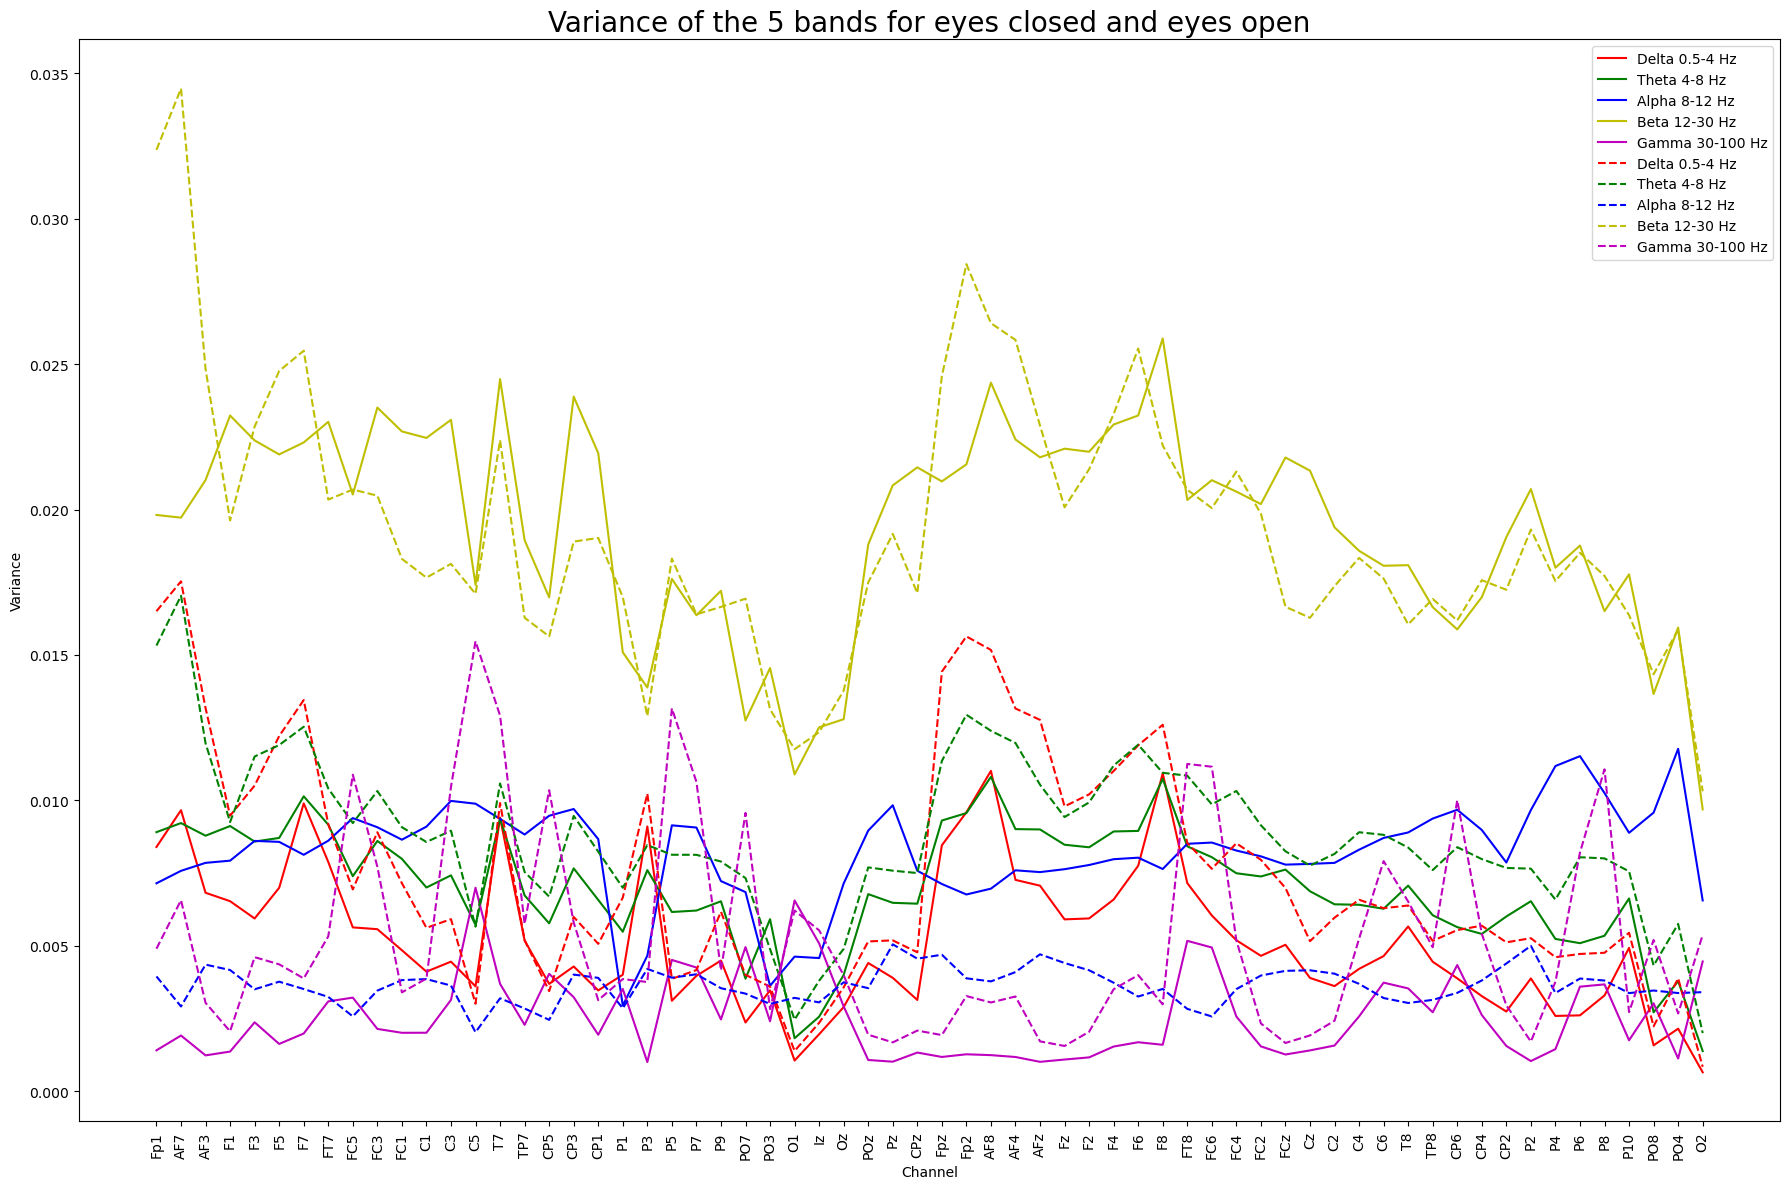

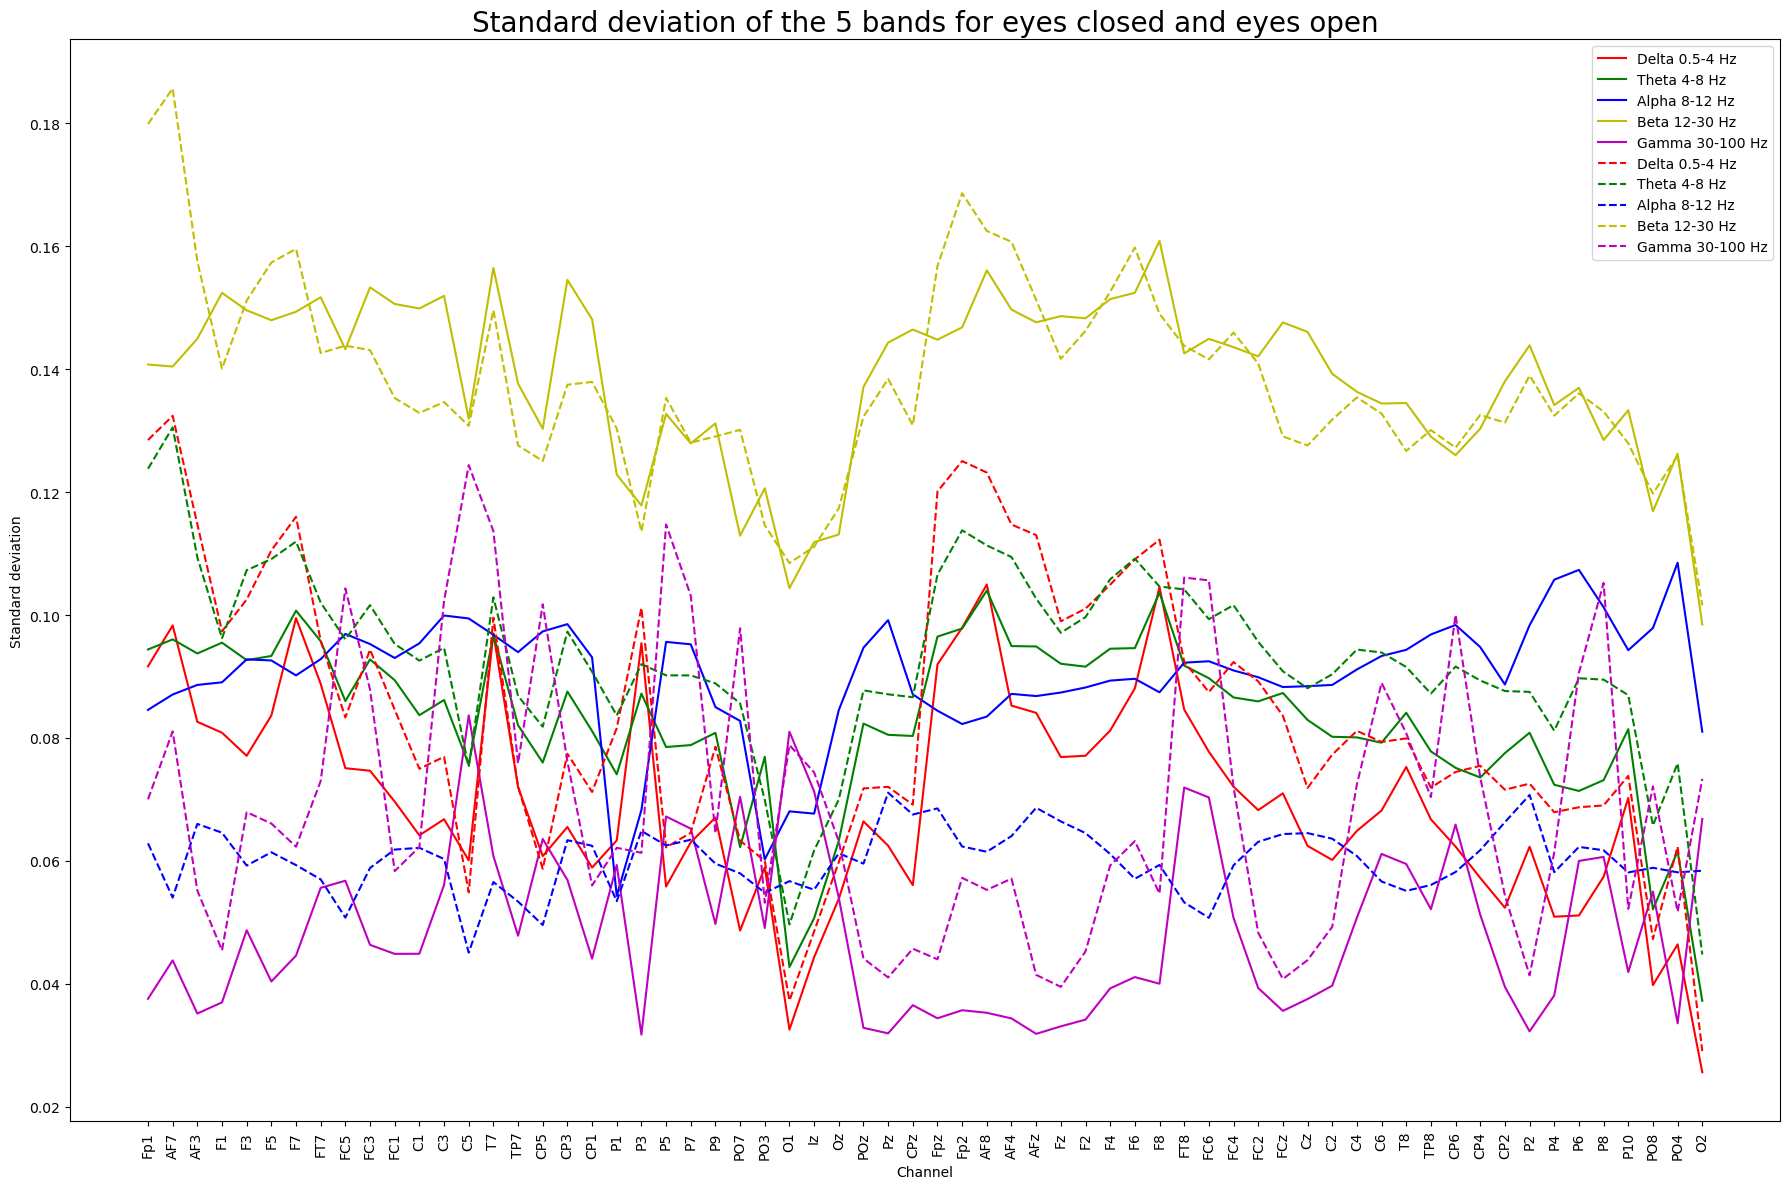

In [29]:
# Line plot to compare the variance of the 5 bands between eyes closed and eyes open datasets
plt.figure(figsize=(18,12))
for i, (band, color) in enumerate(zip(['Delta 0.5-4 Hz', 'Theta 4-8 Hz', 'Alpha 8-12 Hz', 'Beta 12-30 Hz', 'Gamma 30-100 Hz'], ['r', 'g', 'b', 'y', 'm'])):
    plt.plot(raw_closed_filt.ch_names, np.mean(var_band_power_closed[:, :, i], axis=1), color=color, label=band)
for i, (band, color) in enumerate(zip(['Delta 0.5-4 Hz', 'Theta 4-8 Hz', 'Alpha 8-12 Hz', 'Beta 12-30 Hz', 'Gamma 30-100 Hz'], ['r', 'g', 'b', 'y', 'm'])):
    plt.plot(raw_open_filt.ch_names, np.mean(var_band_power_open[:, :, i], axis=1), color=color, linestyle='--', label=band)
plt.title('Variance of the 5 bands for eyes closed and eyes open', fontsize=20)
plt.xlabel('Channel')    
plt.ylabel('Variance')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()  # Adjust to fit into the figure area
plt.show()

# Line plot to compare the standard deviation of the 5 bands between eyes closed and eyes open datasets
plt.figure(figsize=(18,12))
for i, (band, color) in enumerate(zip(['Delta 0.5-4 Hz', 'Theta 4-8 Hz', 'Alpha 8-12 Hz', 'Beta 12-30 Hz', 'Gamma 30-100 Hz'], ['r', 'g', 'b', 'y', 'm'])):
    plt.plot(raw_closed_filt.ch_names, np.mean(std_band_power_closed[:, :, i], axis=1), color=color, label=band)
for i, (band, color) in enumerate(zip(['Delta 0.5-4 Hz', 'Theta 4-8 Hz', 'Alpha 8-12 Hz', 'Beta 12-30 Hz', 'Gamma 30-100 Hz'], ['r', 'g', 'b', 'y', 'm'])):
    plt.plot(raw_open_filt.ch_names, np.mean(std_band_power_open[:, :, i], axis=1), color=color, linestyle='--', label=band)
plt.title('Standard deviation of the 5 bands for eyes closed and eyes open', fontsize=20)
plt.xlabel('Channel')
plt.ylabel('Standard deviation')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()  # Adjust to fit into the figure area
plt.show()



In [30]:
print("Shape of band power closed:", band_power_closed.shape)
print("Shape of std band power closed:", std_band_power_closed.shape)
print("Shape variance of band power closed:", var_band_power_closed.shape)
print("Shape of power ratios closed:", power_ratios_closed.shape)

Shape of band power closed: (64, 479, 5)
Shape of std band power closed: (64, 479, 5)
Shape variance of band power closed: (64, 479, 5)
Shape of power ratios closed: (64, 479, 5)


In [9]:
# Calculate peak to peak amplitude for each epoch and each channel for eyes closed and eyes open

p2p_closed = np.zeros((n_channels, n_epochs_closed, 5))
p2p_open = np.zeros((n_channels, n_epochs_open, 5))

# Calculate the peak to peak amplitude for each epoch and each channel
for i in range(n_channels):
    for j in range(n_epochs_closed):
        p2p_closed[i, j, :] = np.ptp(data_closed_epochs[j, i], axis=0) # peak to peak amplitude for each channel
        
    for j in range(n_epochs_open):
        p2p_open[i, j, :] = np.ptp(data_open_epochs[j, i], axis=0)


# print the shape of the mean peak to peak amplitude
print("Shape of mean peak to peak amplitude for eyes open:", p2p_open.shape)
print("Shape of mean peak to peak amplitude for eyes closed :", p2p_closed.shape)

NameError: name 'n_channels' is not defined

In [61]:
# Calculate Hjorth Parameters: These are simple descriptors of the EEG signal that can be calculated in the time domain. They include activity, mobility, and complexity.
# Formula for hjorth parameters: 
# Activity = variance of the signal
# Mobility = sqrt(var(diff(signal)) / var(signal))
# Complexity = sqrt(var(diff(diff(signal))) / var(diff(signal))

# Calculate hjorth parameters for each epoch and each channel for eyes closed and eyes open
hjorth_closed = np.zeros((n_channels, n_epochs_closed, 3))
hjorth_open = np.zeros((n_channels, n_epochs_open, 3))

# Calculate the hjorth parameters for each epoch and each channel

for i in range(n_channels):
    for j in range(n_epochs_closed):
        hjorth_closed[i, j, 0] = np.var(data_closed_epochs[j, i])  # Activity
        hjorth_closed[i, j, 1] = np.sqrt(np.var(np.diff(data_closed_epochs[j, i])) / np.var(data_closed_epochs[j, i]))  # Mobility
        hjorth_closed[i, j, 2] = np.sqrt(np.var(np.diff(np.diff(data_closed_epochs[j, i]))) / np.var(np.diff(data_closed_epochs[j, i])))  # Complexity
        
    for j in range(n_epochs_open):
        hjorth_open[i, j, 0] = np.var(data_open_epochs[j, i])  # Activity
        hjorth_open[i, j, 1] = np.sqrt(np.var(np.diff(data_open_epochs[j, i])) / np.var(data_open_epochs[j, i]))  # Mobility
        hjorth_open[i, j, 2] = np.sqrt(np.var(np.diff(np.diff(data_open_epochs[j, i]))) / np.var(np.diff(data_open_epochs[j, i])))
        
# print the shape of the hjorth parameters
print("Shape of hjorth parameters for eyes open:", hjorth_open.shape)
print("Shape of hjorth parameters for eyes closed:", hjorth_closed.shape)


Shape of hjorth parameters for eyes open: (64, 551, 3)
Shape of hjorth parameters for eyes closed: (64, 479, 3)


In [13]:
# Create and save the features and labels in a pickle file aswell as the validation set from the eyes open dataset
# Initialize empty lists to hold features 
eyes_closed_features = []
eyes_open_features = []

# Combine all features for eyes closed and eyes open into separate arrays
eyes_closed_features = np.concatenate((band_power_closed, std_band_power_closed, var_band_power_closed, power_ratios_closed, p2p_closed, hjorth_closed), axis=2)
print("Eyes closed features shape ", eyes_closed_features.shape) # Eyes closed features shape  (64, 479, 20)
# For each epoch add the label. Eyes closed = 1, Eyes open = 0
eyes_closed_labels = np.ones((n_epochs_closed, 1))
print("Eyes closed labels shape ", eyes_closed_labels.shape) # Eyes closed labels shape  (479, 1)
print("")
eyes_open_features = np.concatenate((band_power_open, std_band_power_open, var_band_power_open, power_ratios_open, p2p_open, hjorth_open), axis=2)
print("Eyes open features shape ", eyes_open_features.shape) # Eyes open features shape  (64, 551, 20)

eyes_open_labels = np.zeros((n_epochs_open, 1))
print("Eyes open labels shape ", eyes_open_labels.shape) # Eyes open labels shape  (551, 1)

# Randomly select 479 epochs from eyes open dataset to be able to concat the shapes with the eyes closed dataset (N=479)
random_indices = np.random.choice(eyes_open_features.shape[1], size=479, replace=False)
eyes_open_features_equalized = eyes_open_features[:, random_indices, :]
eyes_open_labels_equalized = eyes_open_labels[random_indices]

# Take out the discarded samples from the other left indices and add to a seperate validation set
left_indices = np.setdiff1d(np.arange(eyes_open_features.shape[1]), random_indices) # get the leftover indices
eyes_open_features_final_validation = eyes_open_features[:, left_indices, :]
eyes_open_labels_final_validation = eyes_open_labels[left_indices]

print("")
print("Equalized eyes closed features shape: ", eyes_closed_features.shape)
print("Equalized eyes closed labels shape: ", eyes_closed_labels.shape)
print("Equalized eyes open features shape: ", eyes_open_features_equalized.shape)
print("Equalized eyes open labels shape: ", eyes_open_labels_equalized.shape)
# As they are equalized, the dataset is balanced between the classes.

# Concatenate the features and labels
X = np.concatenate((eyes_closed_features, eyes_open_features_equalized), axis=1)
y = np.concatenate((eyes_closed_labels, eyes_open_labels_equalized), axis=0)
print("")
print("Final features shape: ", X.shape)
print("Final labels shape: ", y.shape)


# print the shape of the final validation set
print("Final validation set features shape: ", eyes_open_features_final_validation.shape)
print("Final validation set labels shape: ", eyes_open_labels_final_validation.shape)

# Save the features and labels in a pickle file
with open('features_x.pickle', 'wb') as f:
    pickle.dump(X, f)
with open('labels_y.pickle', 'wb') as f:
    pickle.dump(y, f)
    
# Save the validation set in a pickle file
with open('validation_features_x.pickle', 'wb') as f:
    pickle.dump(eyes_open_features_final_validation, f)
with open('validation_labels_y.pickle', 'wb') as f:
    pickle.dump(eyes_open_labels_final_validation, f)
    

NameError: name 'band_power_closed' is not defined

In [91]:
# Correlation analysis of the features with the targets
import plotly.graph_objs as go

# Calculate the correlation between the features and the target
correlation = np.zeros((X.shape[0], X.shape[2]))
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        correlation[i, j] = np.abs(np.corrcoef(X[i, :, j], y.flatten())[0, 1])

# Reshape X to a 2D array
X_reshaped = X.reshape(X.shape[1], -1) # X.shape[1] is the number of epochs, -1 is the number of features (64 channels * 20 features = 1280)

# Now concatenate X and y along axis 1
dataWithTarget = np.concatenate((X_reshaped, y), axis= 1)

# Compute the correlation between the features and the target using dataWithTarget
correlation = np.zeros((dataWithTarget.shape[1]-1, 1)) # this initializes the correlation vector
for i in range(dataWithTarget.shape[1]-1): # shape of dataWithTarget (958,1281), 958 epochs with 1280 + label = 1281 features
    correlation[i] = np.corrcoef(dataWithTarget[:, i], dataWithTarget[:, -1])[0, 1]

# Show the correlation vector in correct order as a bar plot
fig = go.Figure(data=[go.Bar(
    x=list(range(dataWithTarget.shape[1]-1)), 
    y=correlation.flatten(),
    text=np.round(correlation.flatten(), 2),
    textposition='auto',
    marker_color=correlation.flatten(), # set color to correlation
    marker=dict(
        colorbar=dict(
            title="Correlation",
        ),
    )
)])

fig.add_shape(type="line", x0=0, y0=0.2, x1=dataWithTarget.shape[1]-1, y1=0.2, line=dict(color="red", width=2))
# The added shape is a horizontal line at y = 0.2 to show the threshold for feature selection

fig.update_layout(
    title_text='Correlation between features and target',
    xaxis_title="Feature",
    yaxis_title="Correlation",
    autosize=False,
    width=1000,
    height=500,
)

fig.show()

In [2]:
# Load features x and labels y from the pickle files if no previous code was run
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

# Load the features and labels from the pickle file
with open('features_x.pickle', 'rb') as f:
    X = pickle.load(f)
    
with open('labels_y.pickle', 'rb') as f:
    y = pickle.load(f)
    
with open('validation_features_x.pickle', 'rb') as f: 
    X_validation = pickle.load(f)
    
with open('validation_labels_y.pickle', 'rb') as f:
    y_validation = pickle.load(f)
    

<font size=5 color=#009999> <b>DIMENSIONALITY REDUCTION </b> <br>
FEATURE EXTRACTION OR FEATURE SELECTION
</font> <br> <br>

<div class="alert alert-info">
<b>[Question 5] Reduce the number of features </b>  <br>
Implement either a feature selection or a feature extraction technique to reduce the number of features in you dataset.
</div> 

Number of components for 95% variance:  62


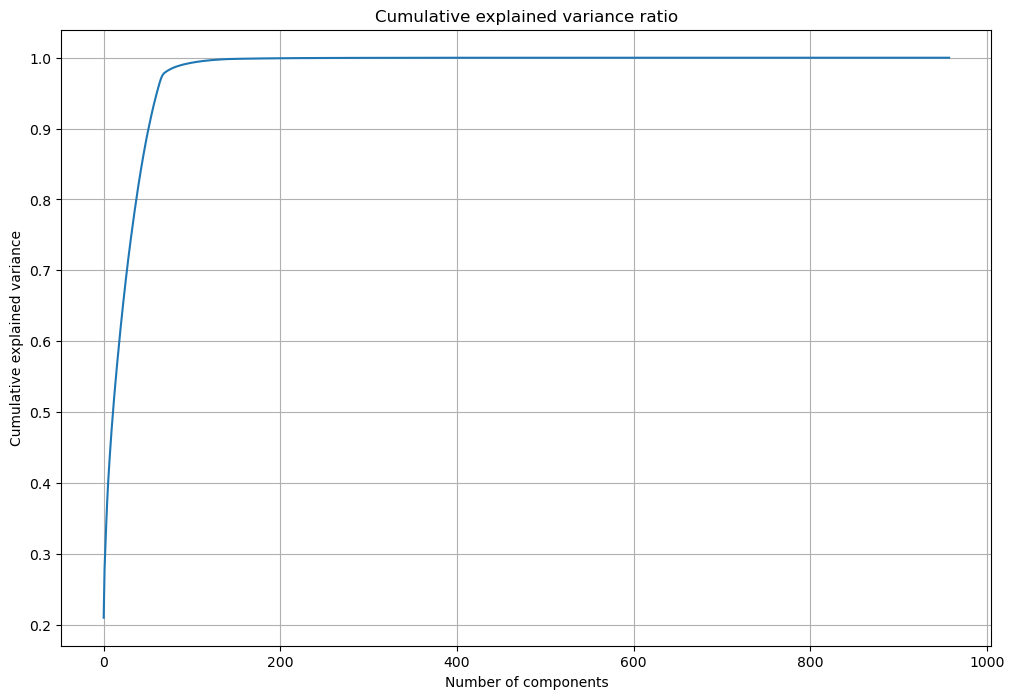

In [5]:
from sklearn.decomposition import PCA

# Reshape data to 2D as PCA does not accept 3D data
# Here we are keeping the epoch dimension (958) and merging the other two (64*20 = 1280)
X_reshaped = X.reshape(X.shape[1], -1)


# Fit PCA with all components
pca = PCA()
pca.fit(X_reshaped)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for 95% variance
n_components = np.where(cumulative_explained_variance > 0.95)[0][0] + 1 # [0][0] to get the first element of the tuple returned by np.where

print("Number of components for 95% variance: ", n_components)

# Plot the explained variance ratio
plt.figure(figsize=(12,8))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance ratio')
plt.grid()
plt.show()

In [6]:
# Correlation analysis of the PCA transformed data with the target
import plotly.graph_objs as go

pca = PCA(n_components=n_components) # Initialize PCA with the number of components for 95% variance from above
X_pca = pca.fit_transform(X_reshaped) # Fit and transform the data
print("Shape of the PCA transformed data: ", X_pca.shape)
print("Shape of original data: ", X_reshaped.shape)

# Concatenate the PCA transformed data with the target
dataWithTarget = np.concatenate((X_pca, y), axis=1)

# Compute the correlation between the features and the target using dataWithTarget
correlation = np.zeros((dataWithTarget.shape[1]-1, 1)) # this initializes the correlation vector
for i in range(dataWithTarget.shape[1]-1): # shape of dataWithTarget (958, 20), 958 epochs with 20 PCA components + label = 21 features
    correlation[i] = np.corrcoef(dataWithTarget[:, i], dataWithTarget[:, -1])[0, 1]

# Show the correlation vector in correct order as a bar plot
fig = go.Figure(data=[go.Bar(
    x=list(range(dataWithTarget.shape[1]-1)),  # x-axis is the number of components, -1 is to exclude the target
    y=correlation.flatten(), # y-axis is the correlation value, flatten is used to convert the 2D array to 1D
    text=np.round(correlation.flatten(), 2),
    textposition='auto',
    marker_color=correlation.flatten(), # set color to correlation
    marker=dict(
        colorbar=dict(
            title="Correlation",
        ),
    )
)])

fig.add_shape(type="line", x0=0, y0=0.2, x1=dataWithTarget.shape[1]-1, y1=0.2, line=dict(color="red", width=2))
# The added shape is a horizontal line at y = 0.2 to show the threshold for feature selection

fig.update_layout(
    title_text='Correlation between PCA components and target',
    xaxis_title="PCA component",
    yaxis_title="Correlation",
    autosize=False,
    width=1000,
    height=500,
)

fig.show()


Shape of the PCA transformed data:  (958, 62)
Shape of original data:  (958, 1792)


In [7]:
# Correlation between non pca data X and the targets y

dataWithTarget = np.concatenate((X_reshaped, y), axis=1)

# Compute the correlation between the features and the target using dataWithTarget
correlation = np.zeros((dataWithTarget.shape[1]-1, 1)) # this initializes the correlation vector
for i in range(dataWithTarget.shape[1]-1): # shape of dataWithTarget (958, 1281), 958 epochs with 1280 + label = 1281 features
    correlation[i] = np.corrcoef(dataWithTarget[:, i], dataWithTarget[:, -1])[0, 1]

# Show the correlation vector in correct order as a bar plot

fig = go.Figure(data=[go.Bar(
    x=list(range(dataWithTarget.shape[1]-1)), 
    y=correlation.flatten(),
    text=np.round(correlation.flatten(), 2),
    textposition='auto',
    marker_color=correlation.flatten(), # set color to correlation
    marker=dict(
        colorbar=dict(
            title="Correlation",
        ),
    )
)])

fig.add_shape(type="line", x0=0, y0=0.2, x1=dataWithTarget.shape[1]-1, y1=0.2, line=dict(color="red", width=2))

fig.update_layout(
    title_text='Correlation between features and target',
    xaxis_title="Feature",
    yaxis_title="Correlation",
    autosize=False,
    width=1000,
    height=500,
)

fig.show()






In [12]:
# Run this to train the models
# Split the data into training and test sets.
# Both for the PCA and non-PCA data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import pickle

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
print("Shape of training data: ", X_train.shape)
print("Shape of training labels: ", y_train.shape)
print("")
print("Shape of test data: ", X_test.shape)
print("Shape of test labels: ", y_test.shape)
print("")
print("Shape of x", X.shape)
print("Shape of y", y.shape)

# Initialize the kfold object
kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5 splits, shuffle the data, random state for reproducibility

##############################################################################################################
print("\nNon PCA data")
# Reshape X to 2D
X_reshaped = X.transpose(1, 0, 2).reshape(X.shape[1], -1)
print("Shape of X_reshaped", X_reshaped.shape)
print("Shape y", y.shape)
# Split the non-PCA data into training and test sets
X_train_noPCA, X_test_noPCA, y_train_noPCA, y_test_noPCA = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# initialize the kfold object
kf_noPCA = KFold(n_splits=5, shuffle=True, random_state=42) # 5 splits, shuffle the data, random state for reproducibility
print("Shape of non pca training data: ", X_train_noPCA.shape)
print("Shape of non pca training labels: ", y_train_noPCA.shape)
print("")
print("Shape of non pca test data: ", X_test_noPCA.shape)
print("Shape of non pca test labels: ", y_test_noPCA.shape)
print("")


print("X validation shape: ", X_validation.shape)
print("y validation shape: ", y_validation.shape)



Shape of training data:  (766, 62)
Shape of training labels:  (766, 1)

Shape of test data:  (192, 62)
Shape of test labels:  (192, 1)

Shape of x (64, 958, 28)
Shape of y (958, 1)

Non PCA data
Shape of X_reshaped (958, 1792)
Shape y (958, 1)
Shape of non pca training data:  (766, 1792)
Shape of non pca training labels:  (766, 1)

Shape of non pca test data:  (192, 1792)
Shape of non pca test labels:  (192, 1)

X validation shape:  (1792, 72)
y validation shape:  (72, 1)


<br><br>

<font size=6 color=#009999> <center><b>PART III - CLASSIFICATION </b></center> </font> <br> <br>

<font size=5 color=#009999> <b>MODEL AND HYPERPARAMETERS SELECTION </b> <br>
K-FOLD
</font> <br> <br>

In order to assess whether the features defined above allow to discriminate between the two conditions (eyes closed or open), you will use classification algorithms. For this task, you are advised to follow the instructions given for the third practical session. In particular, you should consider using a K-Fold cross validation to evaluate your classifiers.
You are asked to use at least two classifiers among the following ones:
   - K-nearest neighbors (kNN)
   - Decision tree
   - Neural network
   - SVM
   
<div class="alert alert-info">
<b>[Question 6] Choose your classifier </b>  <br>
Report the performances obtained with your classifiers (in terms of accuracy) and give some comments. What is a model hyperparameter? How to set the value of an hyperparameter? <br>
You can compare the classification accuracies obtained using different feature sets. For instance, do you obtain better results if you perform a dimensionality reduction (e.g. using PCA) before? (Or if you only use a subset of your features?)
</div> 

In [156]:
# Support Vector Machine (SVM) without any parameters to test - no grid search
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# Initialize the lists to store the accuracy of the model
accuracies = []
start_time = time.time()
# Train a Support Vector Machine on the PCA-transformed data
svm_clf = SVC()

# Loop over each fold
for train_index, test_index in kf.split(X_pca):
    # Split the data into training and test sets
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    svm_clf.fit(X_train, y_train.ravel())
    
    # Make predictions on the test set
    y_pred = svm_clf.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred.ravel())
    
    # Append the accuracy to the list
    accuracies.append(accuracy)
end = time.time()
print("Train time for SVM with PCA: ", end-start_time, "seconds")
print("")
# Calculate the mean accuracy of the model
mean_accuracy = np.mean(accuracies)
print("No hyperparameters SVM model:")
print("Mean accuracy of the model: ", mean_accuracy)
print("Best accuracy of the model: ", max(accuracies))
print("Worst accuracy of the model: ", min(accuracies))

# Higher accuracy with no parameters for svm?

Train time for SVM with PCA:  0.13283467292785645 seconds

No hyperparameters SVM model:
Mean accuracy of the model:  0.5021324171029669
Best accuracy of the model:  0.5287958115183246
Worst accuracy of the model:  0.4635416666666667


In [76]:
# support vector classifier - SVC with GridSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100], # C is the regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
    'gamma': [1, 0.1, 0.01, 0.001], # gamma is the kernel coefficient for 'rbf', 'poly' and 'sigmoid'. The higher the value of gamma, the more the model will try to exactly fit the training data set.
    'kernel': ['rbf', 'poly', 'sigmoid'] # It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable.
}

# Initialize the lists to store the accuracies and best parameters
accuracies = []
best_params = []

#time to run and train
import time
start = time.time()

# Get the total number of folds
total_folds = kf.get_n_splits(X_pca)

# Loop over each fold
for i, (train_index, test_index) in enumerate(kf.split(X_pca), start=1):
    print(f"Training fold {i} of {total_folds}...")
    # Split the data into training and test sets
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create a GridSearchCV object
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=False, cv=5) # refit=True refits the model on the whole dataset using the best parameters, cv is the number of folds
    
    # Fit the model to the data
    grid.fit(X_train, y_train.ravel())
    
    # Store the best parameters
    best_params.append(grid.best_params_)
    
    # Use the best model to make predictions
    y_pred = grid.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)

end = time.time()
print("Time taken to train the model: ", end-start, " seconds")
# Calculate the mean accuracy of the model
mean_accuracy = np.mean(accuracies)
print("-----------------Model Evaluation-----------------")
print("Mean accuracy of the model: ", mean_accuracy)
print("Best accuracy of the model: ", max(accuracies))
print("Worst accuracy of the model: ", min(accuracies))
print("Best parameters in each fold: ", best_params)
print("Best parameters: ", grid.best_params_)

Training fold 1 of 5...
Training fold 2 of 5...
Training fold 3 of 5...
Training fold 4 of 5...
Training fold 5 of 5...
Time taken to train the model:  21.480204105377197  seconds
-----------------Model Evaluation-----------------
Mean accuracy of the model:  0.48432591623036647
Best accuracy of the model:  0.53125
Worst accuracy of the model:  0.4427083333333333
Best parameters in each fold:  [{'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}, {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}, {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}, {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}]
Best parameters:  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [78]:
# DecisionTreeClassifier model

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2,3,4, 5,6,7,8,9],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

# Initialize the lists to store the accuracies and best parameters
accuracies = []
best_params = []

import time
start = time.time()

# Get the total number of folds
total_folds = kf.get_n_splits(X_pca)

# Loop over each fold
for i, (train_index, test_index) in enumerate(kf.split(X_pca), start=1):
    print(f"Training fold {i} of {total_folds}...")
    
    # Split the data into training and test sets
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create a GridSearchCV object
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=False, cv=5)
    
    # Fit the model to the data
    grid.fit(X_train, y_train)
    
    # Store the best parameters
    best_params.append(grid.best_params_)
    
    # Use the best model to make predictions
    y_pred = grid.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)

end = time.time()
print("Time taken to train the model: ", end-start, " seconds")
# Calculate the mean accuracy of the model
mean_accuracy = np.mean(accuracies)
print("DecisionTreeClassifier Model Evaluation")
print("Mean accuracy of the model: ", mean_accuracy)
print("Best accuracy of the model: ", max(accuracies))
print("Worst accuracy of the model: ", min(accuracies))
print("Best parameters in each fold: ", best_params)
print("Best parameters: ", grid.best_params_)

Training fold 1 of 5...
Training fold 2 of 5...
Training fold 3 of 5...
Training fold 4 of 5...
Training fold 5 of 5...
Time taken to train the model:  161.94601702690125  seconds
DecisionTreeClassifier Model Evaluation
Mean accuracy of the model:  0.5042648342059337
Best accuracy of the model:  0.5654450261780105
Worst accuracy of the model:  0.4635416666666667
Best parameters in each fold:  [{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 9}, {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6}, {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9}, {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6}, {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8}]
Best parameters:  {'criterion': 'entropy', '

In [80]:
# Implement a k-Nearest Neighbors classifier
from sklearn.neighbors import KNeighborsClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# Define the parameter grid
param_grid = {
    'n_neighbors': [10,11,12,13,15,20],
    'weights': ['uniform', 'distance'], # Weight function used in prediction. default is uniform
    'metric': ['euclidean', 'manhattan', 'minkowski'], # Metric to use for distance computation. default is minkowski
    'leaf_size': [1,2,3,4,5,10,], # Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. default 30
}

# Initialize the lists to store the accuracies and best parameters
accuracies = []
best_params = []

import time
start = time.time()

# Get the total number of folds
total_folds = kf.get_n_splits(X_pca)

# Loop over each fold
for i, (train_index, test_index) in enumerate(kf.split(X_pca), start=1):
    print(f"Training fold {i} of {total_folds}...")
    
    # Split the data into training and test sets
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create a GridSearchCV object
    grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=False, cv=5)
    
    # Fit the model to the data
    grid.fit(X_train, y_train.ravel())
    
    # Store the best parameters
    best_params.append(grid.best_params_)
    
    # Use the best model to make predictions
    y_pred = grid.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)

end = time.time()
print("Time taken to train the model: ", end-start, " seconds")
# Calculate the mean accuracy of the model
mean_accuracy = np.mean(accuracies)

print("KNeighborsClassifier Model Evaluation")
print("Mean accuracy of the model: ", mean_accuracy)
print("Best accuracy of the model: ", max(accuracies))
print("Worst accuracy of the model: ", min(accuracies))
print("Best parameters in each fold: ", best_params)
print("Best parameters: ", grid.best_params_)


Training fold 1 of 5...
Training fold 2 of 5...
Training fold 3 of 5...
Training fold 4 of 5...
Training fold 5 of 5...
Time taken to train the model:  62.69004535675049  seconds
KNeighborsClassifier Model Evaluation
Mean accuracy of the model:  0.5166884816753926
Best accuracy of the model:  0.5968586387434555
Worst accuracy of the model:  0.42408376963350786
Best parameters in each fold:  [{'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}, {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'}, {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}, {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}, {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}]
Best parameters:  {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}


In [151]:
# Implement random forest classifier
from sklearn.ensemble import RandomForestClassifier
import time

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [10, 20, 30], # The number of trees in the forest
    'criterion': ['gini', 'entropy'], # The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
    'max_depth': [None, 2, 8], # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    'min_samples_split': [2, 4], # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'], # The number of features to consider when looking for the best split
}

# Initialize the lists to store the accuracies and best parameters
rf_accuracies = []
rf_best_params = []

start = time.time() 
# Get the total number of folds
n_fold = kf.get_n_splits(X_pca)

# Loop over each fold
for i, (train_index, test_index) in enumerate(kf.split(X_pca), start=1):
    print(f"Training fold {i} of {n_fold}...")
    
    # Split the data into training and test sets
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create a GridSearchCV object
    rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, refit=True, verbose=False, cv=5)
    
    # Fit the model to the data
    rf_grid.fit(X_train, y_train.ravel())
    
    # Store the best parameters
    rf_best_params.append(rf_grid.best_params_)
    
    # Use the best model to make predictions
    y_pred = rf_grid.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    rf_accuracies.append(accuracy)
end = time.time()
print("Time taken to train the model: ", end-start, " seconds")
print("")
# Calculate the mean accuracy of the model
rf_mean_accuracy = np.mean(rf_accuracies)
print("Mean accuracy of the model: ", rf_mean_accuracy)
print("Best accuracy of the model: ", max(rf_accuracies))
print("Worst accuracy of the model: ", min(rf_accuracies))
print("Best parameters in each fold: ", rf_best_params)
print("Best parameters: ", rf_grid.best_params_)


Training fold 1 of 5...
Training fold 2 of 5...
Training fold 3 of 5...
Training fold 4 of 5...
Training fold 5 of 5...
Time taken to train the model:  289.4790394306183  seconds

Mean accuracy of the model:  0.5115783158813263
Best accuracy of the model:  0.5916230366492147
Worst accuracy of the model:  0.4375
Best parameters in each fold:  [{'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}, {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}, {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 30}, {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 30}, {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 30}]
Be

In [11]:
# Implement a Gradient Boosting Classifier on non PCA data
from sklearn.ensemble import GradientBoostingClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
gb_param_grid = {
    'n_estimators': [10, 20, 30], # The number of boosting stages to be run
    'learning_rate': [0.1, 0.01], # The learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5], # The maximum depth of the individual estimators
    'min_samples_split': [2, 4], # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4], # The minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'], # The number of features to consider when looking for the best split
}

# Initialize the lists to store the accuracies and best parameters
gb_accuracies = []
gb_best_params = []

start = time.time()

# Get the total number of folds
n_fold = kf.get_n_splits(X_reshaped)

# Loop over each fold
for i, (train_index, test_index) in enumerate(kf_noPCA.split(X_reshaped), start=1):
    print(f"Training fold {i} of {n_fold}...")
    
    # Split the data into training and test sets
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create a GridSearchCV object
    gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, refit=True, verbose=False, cv=5)
    
    # Fit the model to the data
    gb_grid.fit(X_train, y_train.ravel())
    
    # Store the best parameters
    gb_best_params.append(gb_grid.best_params_)
    
    # Use the best model to make predictions
    y_pred = gb_grid.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    gb_accuracies.append(accuracy)
end = time.time()

print("Time taken to train the model: ", end-start, " seconds")
print("")

# Calculate the mean accuracy of the model
gb_mean_accuracy = np.mean(gb_accuracies)
print("Mean accuracy of the model: ", gb_mean_accuracy)
print("Best accuracy of the model: ", max(gb_accuracies))
print("Worst accuracy of the model: ", min(gb_accuracies))
print("Best parameters in each fold: ", gb_best_params)
print("Best parameters: ", gb_grid.best_params_)
print("")

# Test best params in gb_param_grid on the validation set
y_pred = gb_grid.predict(X_validation)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_validation, y_pred)
print("Accuracy of the gradient boost model on the validation set: ", accuracy)

Training fold 1 of 5...
Training fold 2 of 5...
Training fold 3 of 5...
Training fold 4 of 5...
Training fold 5 of 5...
Time taken to train the model:  189.7731990814209  seconds

Mean accuracy of the model:  1.0
Best accuracy of the model:  1.0
Worst accuracy of the model:  1.0
Best parameters in each fold:  [{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}]
Best parameters:  {'learning_rate

ValueError: X has 72 features, but GradientBoostingClassifier is expecting 1792 features as input.

In [178]:
# k-NNModel to classify X_train_noPCA, X_test_noPCA, y_train_noPCA, y_test_noPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

#small param grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Calculate the total number of folds
total_folds = kf_noPCA.get_n_splits(X_reshaped)
# Initialize the lists to store the accuracies
knn_accuracies = []
knn_best_params = []

start = time.time()

for i, (train_index, test_index) in enumerate(kf_noPCA.split(X_reshaped), start=1):
    print(f"Training fold {i} of {total_folds}...")
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create a GridSearchCV object
    knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, refit=True, verbose=False, cv=5)
    
    # Fit the model to the data
    knn_grid.fit(X_train, y_train.ravel())
    
    # Store the best parameters
    knn_best_params.append(knn_grid.best_params_)
    
    # Use the best model to make predictions
    y_pred = knn_grid.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    knn_accuracies.append(accuracy)

end = time.time()
print("Time taken to train the model: ", end-start, " seconds")
print("")
# Calculate the mean accuracy of the model
knn_mean_accuracy = np.mean(knn_accuracies)
print("KNN on non pca data")
print("Mean accuracy of the model: ", knn_mean_accuracy)
print("Best accuracy of the model: ", max(knn_accuracies))
print("Worst accuracy of the model: ", min(knn_accuracies))
print("Best parameters in each fold: ", knn_best_params)
print("Best parameters: ", knn_grid.best_params_)

# Test the best knn model on validation set

y_pred = knn_grid.predict(X_validation)
accuracy = accuracy_score(y_validation, y_pred)
print("")
print("Accuracy of the best knn model on the validation set: ", accuracy)



Training fold 1 of 5...
Training fold 2 of 5...
Training fold 3 of 5...
Training fold 4 of 5...
Training fold 5 of 5...
Time taken to train the model:  16.96989679336548  seconds

KNN on non pca data
Mean accuracy of the model:  0.996864092495637
Best accuracy of the model:  1.0
Worst accuracy of the model:  0.9895287958115183
Best parameters in each fold:  [{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}, {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}, {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}, {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}, {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}]
Best parameters:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}

Accuracy of the best knn model on the validation set:  0.5138888888888888


<font size=5 color=#009999> <b>EVALUATE YOUR BEST MODEL ON THE TEST SET </b> <br>
WHAT ARE YOUR CONCLUSIONS?
</font> <br> <br>

   
<div class="alert alert-info">
<b>[Question 7] Performance on the test set </b>  <br>
Now that you have selected the best model (and its best hyperparameters), evaluate its performance on the test set. Comment.
</div> 

In [ ]:
# Insert your code here

